**Assignment:**
1. Discussion of cancer rates by state for the different cancer types
2. Investigation of correlation between rates of a given cancer type and the provided features
3. Predictive modeling of cancer rates using the provided features
4. Visualization of any insights generated by the analysis

**Submission:**
    
**1. For Total counts of cancer occurrences for 2014-2018 for three major cancer types:**

1.1 Discussion of cancer rates 

**cancer rates vs. gender**

* Breast Cancer Rate Increase from Male to Female: In Breast cancer occurrences, the number of female patients is 133.21424616583593 more than that of male patients.
* Lung and Bronchus Cancer Rate Increase from Male to Female: In Lung and Bronchus cancer occurrence, the number of female patients is 0.05898999751265312 less than male patients.
* Melanoma of the Skin Cancer Rate Increase from Male to Female: In Melanoma of the skin cancer occurrences, the number of female patients is 0.3126733058429545 less than that of male patients.
    
**cancer rates vs. age groups**

* Breast Cancer Rate Increase from 25 to 44 group to 45 to 64 group: the number of patients increase 3.8355149884429744
* Breast Cancer Rate Increase from 45 to 64 group to 65+ group: the number of patients increase 0.07915880360323235
* Lung and Bronchus Cancer Rate Increase from 25 to 44 group to 45 to 64 group: the number of patients increase 24.447478898134126
* Lung and Bronchus Cancer Rate Increase from 45 to 64 group to 65+ group: the number of patients increase 1.4210450508719916
* Melanoma of the Skin Cancer Rate Increase from 25 to 44 group to 45 to 64 group: the number of patients increase 2.4221222626889998
* Melanoma of the Skin Cancer Rate Increase from 45 to 64 group to 65+ group: the number of patients increase 0.5337287561570329

1.2 Data Modeling: Cancer Rates Prediction with LSTM Time Series Model
    
**Performance**

* LSTM Time Series Model: RMSE = 0.003

1.3 Insights Analysis and Visualization: For high/low cancer rate groups
* the number of states in high/low groups
* the groups description with lower/average/upper bounds

**2. Combination of Smoking Rate Data with Lung cancer total counts:**

2.1 Data description and correlation description

2.2 Data Modeling: cancer rate prediction by using smoking rate and Lung and Bronchus cancer data features
    
**Performance**

* Logistic regression: ROC=1.0 average precision=1.0

* Decision tree with depth of two: ROC=1.0 average precision=1.0

* Decision tree - unlimited depth: ROC=1.0 average precision=1.0

* Random forest: ROC=1.0 average precision=1.0

2.3 Insights Analysis and Visualization: cancer rates vs. 'measuredesc','response','gender','topicdesc','age_group','data_value'

**3. Combination of Population and Economic_Indicators with three cancer total counts:**

3.1 Data description and correlation description

3.2 Data Modeling: cancer rate prediction with LSTM by using population, economic_indicators, and three cancer features

**Performance**

* LSTM on Breast Cancer dataset: RMSE = 0.003

* LSTM on Lung and Bronchus dataset: RMSE = 0.003
    
* LSTM on Melanoma of the Skin Cancer dataset: RMSE = 0.001
    
3.3 Insights Analysis and Visualization: cancer rates vs. 'population', 'real_gdp', 'real_personal_income','personal_income', 'disposable_personal_income', 'pce', 'regional_price_parities', 'n_jobs', 'regional_price_deflator'

In [2]:
import pandas as pd
import numpy as np
import re
import math
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
    
import seaborn as sns
import matplotlib.pyplot as plt

2023-11-21 13:44:29.310335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preprocessing

In [3]:
with open('data/cdc_smoking_data.json', encoding='utf-8') as inputfile:
    df = pd.read_json(inputfile)
df.to_csv('data/cdc_smoking_data.csv', encoding='utf-8', index=False)

In [4]:
import sqlite3
conn = sqlite3.connect('data/population_data.db', isolation_level=None,
                       detect_types=sqlite3.PARSE_COLNAMES)
db_df = pd.read_sql_query("SELECT * FROM population", conn)
db_df.to_csv('data/population.csv', index=False)
db_df = pd.read_sql_query("SELECT * FROM economic_indicators", conn)
db_df.to_csv('data/economic_indicators.csv', index=False)
conn.close()

In [5]:
def convert_txt_to_csv(infile, outfile):
    with open(infile,'r') as f:
        r = f.readlines()
        df_records = []
        for aline in r:
            if len(aline.split('\t'))>1:
                df_records.append([re.sub(r'[\"\n]', '',r) for r in aline.split('\t')[1:]])   
        df_records[0] = [r.strip() for r in df_records[0]]
        df_records = pd.DataFrame(df_records)
        df_records.to_csv(outfile,header=None, index=None)
        
convert_txt_to_csv('data/cancer_count_by_state_year_agegte25lt45.txt','data/cancer_count_by_state_year_agegte25lt45.csv') 
convert_txt_to_csv('data/cancer_count_by_state_year_agegte45lt65.txt','data/cancer_count_by_state_year_agegte45lt65.csv')
convert_txt_to_csv('data/cancer_count_by_state_year_agegte65.txt','data/cancer_count_by_state_year_agegte65.csv')

In [6]:
df_population = pd.read_csv('data/population.csv')
df_economic_indicators = pd.read_csv('data/economic_indicators.csv')
df_cdc_smoking = pd.read_csv('data/cdc_smoking_data.csv')
df_cancer_2545 = pd.read_csv('data/cancer_count_by_state_year_agegte25lt45.csv')
df_cancer_2545['age_group'] = '25 to 44'
df_cancer_4565 = pd.read_csv('data/cancer_count_by_state_year_agegte45lt65.csv')
df_cancer_4565['age_group'] = '45 to 64'
df_cancer_65 = pd.read_csv('data/cancer_count_by_state_year_agegte65.csv')
df_cancer_65['age_group'] = '65+'

In [7]:
df_cancer_65.columns

Index(['Leading Cancer Sites', 'Leading Cancer Sites Code', 'States',
       'States Code', 'Year', 'Year Code', 'Sex', 'Sex Code', 'Count',
       'age_group'],
      dtype='object')

In [8]:
df_cdc_smoking.columns

Index(['year', 'locationabbr', 'locationdesc', 'topictype', 'topicdesc',
       'measuredesc', 'response', 'data_value_unit', 'data_value', 'gender',
       'data_value_footnote_symbol', 'data_value_footnote'],
      dtype='object')

In [9]:
df_economic_indicators.columns

Index(['fips', 'year', 'real_gdp', 'real_personal_income', 'real_pce', 'gdp',
       'personal_income', 'disposable_personal_income', 'pce',
       'regional_price_parities', 'n_jobs', 'regional_price_deflator'],
      dtype='object')

In [10]:
df_population.columns

Index(['fips', 'year', 'sex', 'age_group', 'population'], dtype='object')

In [11]:
df_cancer_2545.head()

,Leading Cancer Sites,Leading Cancer Sites Code,States,States Code,Year,Year Code,Sex,Sex Code,Count,age_group
0,Breast,26000,Alabama,1,2014,2014,Female,F,359,25 to 44
1,Breast,26000,Alabama,1,2014,2014,Male,M,Suppressed,25 to 44
2,Breast,26000,Alabama,1,2015,2015,Female,F,349,25 to 44
3,Breast,26000,Alabama,1,2015,2015,Male,M,0,25 to 44
4,Breast,26000,Alabama,1,2016,2016,Female,F,383,25 to 44


In [12]:
df_cancer_4565['Count'].nunique(),df_cancer_2545[df_cancer_4565['Count']=='Missing']['Count'].nunique()

(818, 1)

In [13]:
df_cancer = pd.concat([df_cancer_2545, df_cancer_4565, df_cancer_65],axis=0)
df_cancer_transformed = df_cancer.drop_duplicates().copy()
df_cancer_transformed['Count'] = df_cancer_transformed['Count'].apply(lambda t: 0 if not t.isdigit() else int(t))
df_cancer_transformed.to_csv('data/cancer_clean.csv',index=False)
df_cancer_transformed.head()

,Leading Cancer Sites,Leading Cancer Sites Code,States,States Code,Year,Year Code,Sex,Sex Code,Count,age_group
0,Breast,26000,Alabama,1,2014,2014,Female,F,359,25 to 44
1,Breast,26000,Alabama,1,2014,2014,Male,M,0,25 to 44
2,Breast,26000,Alabama,1,2015,2015,Female,F,349,25 to 44
3,Breast,26000,Alabama,1,2015,2015,Male,M,0,25 to 44
4,Breast,26000,Alabama,1,2016,2016,Female,F,383,25 to 44


## 1. Discussion about Cancer Rates for Three Cancer Types

### For different age groups,
#### Breast Cancer Rate Increase from 25 to 44 group to 45 to 64 group:  3.8355149884429744
#### Breast Cancer Rate Increase from 45 to 64 group to 65+ group:  0.07915880360323235
#### Lung and Bronchus Cancer Rate Increase from 25 to 44 group to 45 to 64 group:  24.447478898134126
#### Lung and Bronchus Cancer Rate Increase from 45 to 64 group to 65+ group:  1.4210450508719916
#### Melanoma of the Skin Cancer Rate Increase from 25 to 44 group to 45 to 64 group:  2.4221222626889998
#### Melanoma of the Skin Cancer Rate Increase from 45 to 64 group to 65+ group:  0.5337287561570329

In [14]:

df_cancer_transformed = pd.read_csv('data/cancer_clean.csv')

df_cancer_transformed = df_cancer_transformed[['Leading Cancer Sites','States', \
                                               'Year','Sex Code', 'age_group','Count']].copy()
df_cancer_transformed_grouped = df_cancer_transformed.groupby(['Leading Cancer Sites','States', \
                                                'age_group', 'Sex Code'])
df_cancer_transformed_sum = []
for k, g in df_cancer_transformed_grouped:
    #print(list(k)+[g['Count'].sum(), g['Count'].mean()])
    df_cancer_transformed_sum.append(list(k)+[g['Count'].sum(), g['Count'].mean()])
    
df_cancer_transformed_grouped = pd.DataFrame(df_cancer_transformed_sum,columns=['Leading Cancer Sites','States', \
                                                'age_group','Sex Code','Count_sum','Count_mean'])
df_cancer_transformed_grouped.to_csv('data/cancer_tranformed_rates.csv', index=False)
df_cancer_transformed_grouped.head()

,Leading Cancer Sites,States,age_group,Sex Code,Count_sum,Count_mean
0,Breast,Alabama,25 to 44,F,1812,362.4
1,Breast,Alabama,25 to 44,M,0,0.0
2,Breast,Alabama,45 to 64,F,8142,1628.4
3,Breast,Alabama,45 to 64,M,75,15.0
4,Breast,Alabama,65+,F,8945,1789.0


In [15]:
df_cancer_transformed_grouped_age = df_cancer_transformed_grouped.groupby(['Leading Cancer Sites','States', \
                                                ])
df_age_group = []
for k, g in df_cancer_transformed_grouped_age:
    df_age_group.append(list(k)+[g[g['age_group']=='25 to 44']['Count_sum'].sum(),g[g['age_group']=='45 to 64']['Count_sum'].sum(), g[g['age_group']=='65+']['Count_sum'].sum()])
df_age_group = pd.DataFrame(df_age_group, columns=['Leading Cancer Sites','States','25 to 44','45 to 64','65+'])
df_age_group['increase_25_44_45_64'] = df_age_group[['25 to 44','45 to 64']].apply(lambda s: (s[1]-s[0])/s[0] if s[0]>0 else 0, axis=1)
df_age_group['increase_45_64_65+'] = df_age_group[['45 to 64','65+']].apply(lambda s: (s[1]-s[0])/s[0] if s[0]>0 else 0, axis=1)
df_age_group.head()

,Leading Cancer Sites,States,25 to 44,45 to 64,65+,increase_25_44_45_64,increase_45_64_65+
0,Breast,Alabama,1812,8217,9072,3.534768,0.104053
1,Breast,Alaska,263,1106,802,3.205323,-0.274864
2,Breast,Arizona,2116,9865,12504,3.662098,0.267511
3,Breast,Arkansas,1015,4708,5451,3.638424,0.157816
4,Breast,California,14239,61361,60617,3.309362,-0.012125


In [16]:
print('Breast Cancer Rate Increase from 25 to 44 group to 45 to 64 group: ',df_age_group[df_age_group['Leading Cancer Sites']=='Breast']['increase_25_44_45_64'].mean())
print('Breast Cancer Rate Increase from 45 to 64 group to 65+ group: ',df_age_group[df_age_group['Leading Cancer Sites']=='Breast']['increase_45_64_65+'].mean())
print('Lung and Bronchus Cancer Rate Increase from 25 to 44 group to 45 to 64 group: ',df_age_group[df_age_group['Leading Cancer Sites']=='Lung and Bronchus']['increase_25_44_45_64'].mean())
print('Lung and Bronchus Cancer Rate Increase from 45 to 64 group to 65+ group: ',df_age_group[df_age_group['Leading Cancer Sites']=='Lung and Bronchus']['increase_45_64_65+'].mean())
print('Melanoma of the Skin Cancer Rate Increase from 25 to 44 group to 45 to 64 group: ',df_age_group[df_age_group['Leading Cancer Sites']=='Melanoma of the Skin']['increase_25_44_45_64'].mean())
print('Melanoma of the Skin Cancer Rate Increase from 45 to 64 group to 65+ group: ',df_age_group[df_age_group['Leading Cancer Sites']=='Melanoma of the Skin']['increase_45_64_65+'].mean())

Breast Cancer Rate Increase from 25 to 44 group to 45 to 64 group:  3.8355149884429744
Breast Cancer Rate Increase from 45 to 64 group to 65+ group:  0.07915880360323235
Lung and Bronchus Cancer Rate Increase from 25 to 44 group to 45 to 64 group:  24.447478898134126
Lung and Bronchus Cancer Rate Increase from 45 to 64 group to 65+ group:  1.4210450508719916
Melanoma of the Skin Cancer Rate Increase from 25 to 44 group to 45 to 64 group:  2.4221222626889998
Melanoma of the Skin Cancer Rate Increase from 45 to 64 group to 65+ group:  0.5337287561570329


### For different genders, 
#### Breast Cancer Rate Increase from Male to Female:  133.21424616583593
#### Lung and Bronchus Cancer Rate Increase from Male to Female:  -0.05898999751265312
#### Melanoma of the Skin Cancer Rate Increase from Male to Female:  -0.3126733058429545

In [17]:
df_cancer_transformed_grouped_gender = df_cancer_transformed_grouped.groupby(['Leading Cancer Sites','States'])
df_gender = []
for k, g in df_cancer_transformed_grouped_gender:
    df_gender.append(list(k)+[g[g['Sex Code']=='M']['Count_sum'].sum(),g[g['Sex Code']=='F']['Count_sum'].sum()])
df_gender = pd.DataFrame(df_gender, columns=['Leading Cancer Sites','States','M_sum','F_sum'])
df_gender['increase_M_F'] = df_gender[['M_sum','F_sum']].apply(lambda s: (s[1]-s[0])/s[0] if s[0]>0 else 0, axis=1)
df_gender.head()

,Leading Cancer Sites,States,M_sum,F_sum,increase_M_F
0,Breast,Alabama,202,18899,92.559406
1,Breast,Alaska,0,2171,0.000000
2,Breast,Arizona,209,24276,115.153110
3,Breast,Arkansas,16,11158,696.375000
4,Breast,California,947,135270,141.840549


In [18]:
print('Breast Cancer Rate Increase from Male to Female: ',df_gender[df_gender['Leading Cancer Sites']=='Breast']['increase_M_F'].mean())
print('Lung and Bronchus Cancer Rate Increase from Male to Female: ',df_gender[df_gender['Leading Cancer Sites']=='Lung and Bronchus']['increase_M_F'].mean())
print('Melanoma of the Skin Cancer Rate Increase from Male to Female: ',df_gender[df_gender['Leading Cancer Sites']=='Melanoma of the Skin']['increase_M_F'].mean())

Breast Cancer Rate Increase from Male to Female:  133.21424616583593
Lung and Bronchus Cancer Rate Increase from Male to Female:  -0.05898999751265312
Melanoma of the Skin Cancer Rate Increase from Male to Female:  -0.3126733058429545


### Cancer Rates Prediction with LSTM Time Series Model

In [19]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = data.values #scaler.fit_transform(data.values)
    df = pd.DataFrame(scaled)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

df_cancer = pd.read_csv('data/cancer_clean.csv')

df_cancer_shift = []
for k, g in df_cancer[df_cancer['Leading Cancer Sites']=='Breast'].groupby(['Leading Cancer Sites Code','States Code','age_group','Sex Code']):
    #print(k, g)
    r = series_to_supervised(g[['Count']], n_in=1, n_out=1, dropnan=True)
    df_cancer_shift.append(r.values)
    
    
# split into train and test sets
values = np.array(df_cancer_shift)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values.reshape(-1,2))
values = scaled.reshape(-1,4,2)
n_train_hours = int(values.shape[0]*0.67)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:,:, :-1], train[:,:, -1]
test_X, test_y = test[:,:, :-1], test[:,:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape(-1,2).reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape(-1,2).reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)



(205, 1, 4) (205, 4) (101, 1, 4) (101, 4)
Epoch 1/500
3/3 - 3s - loss: 0.0625 - val_loss: 0.0546 - 3s/epoch - 1s/step
Epoch 2/500
3/3 - 0s - loss: 0.0602 - val_loss: 0.0529 - 52ms/epoch - 17ms/step
Epoch 3/500
3/3 - 0s - loss: 0.0581 - val_loss: 0.0509 - 61ms/epoch - 20ms/step
Epoch 4/500
3/3 - 0s - loss: 0.0558 - val_loss: 0.0487 - 60ms/epoch - 20ms/step
Epoch 5/500
3/3 - 0s - loss: 0.0533 - val_loss: 0.0464 - 58ms/epoch - 19ms/step
Epoch 6/500
3/3 - 0s - loss: 0.0510 - val_loss: 0.0444 - 56ms/epoch - 19ms/step
Epoch 7/500
3/3 - 0s - loss: 0.0488 - val_loss: 0.0422 - 65ms/epoch - 22ms/step
Epoch 8/500
3/3 - 0s - loss: 0.0463 - val_loss: 0.0400 - 54ms/epoch - 18ms/step
Epoch 9/500
3/3 - 0s - loss: 0.0439 - val_loss: 0.0379 - 45ms/epoch - 15ms/step
Epoch 10/500
3/3 - 0s - loss: 0.0414 - val_loss: 0.0356 - 63ms/epoch - 21ms/step
Epoch 11/500
3/3 - 0s - loss: 0.0388 - val_loss: 0.0332 - 60ms/epoch - 20ms/step
Epoch 12/500
3/3 - 0s - loss: 0.0361 - val_loss: 0.0307 - 53ms/epoch - 18ms/step

Epoch 102/500
3/3 - 0s - loss: 0.0025 - val_loss: 0.0019 - 44ms/epoch - 15ms/step
Epoch 103/500
3/3 - 0s - loss: 0.0024 - val_loss: 0.0019 - 43ms/epoch - 14ms/step
Epoch 104/500
3/3 - 0s - loss: 0.0024 - val_loss: 0.0020 - 48ms/epoch - 16ms/step
Epoch 105/500
3/3 - 0s - loss: 0.0024 - val_loss: 0.0022 - 49ms/epoch - 16ms/step
Epoch 106/500
3/3 - 0s - loss: 0.0025 - val_loss: 0.0022 - 50ms/epoch - 17ms/step
Epoch 107/500
3/3 - 0s - loss: 0.0024 - val_loss: 0.0022 - 47ms/epoch - 16ms/step
Epoch 108/500
3/3 - 0s - loss: 0.0026 - val_loss: 0.0019 - 49ms/epoch - 16ms/step
Epoch 109/500
3/3 - 0s - loss: 0.0025 - val_loss: 0.0019 - 42ms/epoch - 14ms/step
Epoch 110/500
3/3 - 0s - loss: 0.0024 - val_loss: 0.0019 - 48ms/epoch - 16ms/step
Epoch 111/500
3/3 - 0s - loss: 0.0024 - val_loss: 0.0020 - 48ms/epoch - 16ms/step
Epoch 112/500
3/3 - 0s - loss: 0.0024 - val_loss: 0.0022 - 48ms/epoch - 16ms/step
Epoch 113/500
3/3 - 0s - loss: 0.0025 - val_loss: 0.0022 - 47ms/epoch - 16ms/step
Epoch 114/500
3/

Epoch 202/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0019 - 47ms/epoch - 16ms/step
Epoch 203/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 48ms/epoch - 16ms/step
Epoch 204/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 48ms/epoch - 16ms/step
Epoch 205/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0019 - 48ms/epoch - 16ms/step
Epoch 206/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 50ms/epoch - 17ms/step
Epoch 207/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0018 - 49ms/epoch - 16ms/step
Epoch 208/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0019 - 44ms/epoch - 15ms/step
Epoch 209/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0019 - 47ms/epoch - 16ms/step
Epoch 210/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0019 - 49ms/epoch - 16ms/step
Epoch 211/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 55ms/epoch - 18ms/step
Epoch 212/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 43ms/epoch - 14ms/step
Epoch 213/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0019 - 43ms/epoch - 14ms/step
Epoch 214/500
3/

Epoch 302/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0018 - 49ms/epoch - 16ms/step
Epoch 303/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0019 - 48ms/epoch - 16ms/step
Epoch 304/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0019 - 45ms/epoch - 15ms/step
Epoch 305/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0019 - 48ms/epoch - 16ms/step
Epoch 306/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 48ms/epoch - 16ms/step
Epoch 307/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 49ms/epoch - 16ms/step
Epoch 308/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0019 - 48ms/epoch - 16ms/step
Epoch 309/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 49ms/epoch - 16ms/step
Epoch 310/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0018 - 48ms/epoch - 16ms/step
Epoch 311/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0019 - 48ms/epoch - 16ms/step
Epoch 312/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0019 - 48ms/epoch - 16ms/step
Epoch 313/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0019 - 48ms/epoch - 16ms/step
Epoch 314/500
3/

Epoch 402/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0019 - 49ms/epoch - 16ms/step
Epoch 403/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 43ms/epoch - 14ms/step
Epoch 404/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0018 - 47ms/epoch - 16ms/step
Epoch 405/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0019 - 47ms/epoch - 16ms/step
Epoch 406/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 44ms/epoch - 15ms/step
Epoch 407/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0019 - 49ms/epoch - 16ms/step
Epoch 408/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 47ms/epoch - 16ms/step
Epoch 409/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0018 - 42ms/epoch - 14ms/step
Epoch 410/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0019 - 48ms/epoch - 16ms/step
Epoch 411/500
3/3 - 0s - loss: 0.0023 - val_loss: 0.0018 - 47ms/epoch - 16ms/step
Epoch 412/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0017 - 47ms/epoch - 16ms/step
Epoch 413/500
3/3 - 0s - loss: 0.0022 - val_loss: 0.0019 - 47ms/epoch - 16ms/step
Epoch 414/500
3/

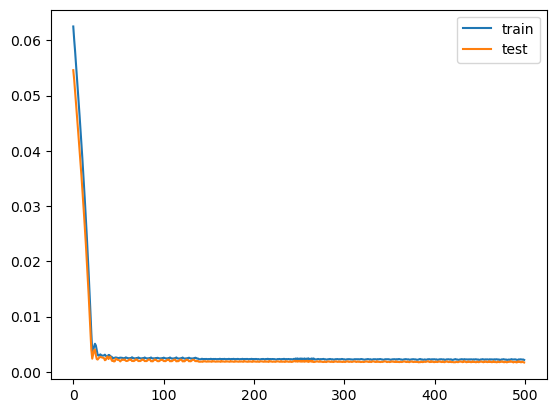

4/4 [==============================] - 1s 3ms/step
Test RMSE: 0.003


In [20]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# make a prediction
yhat = model.predict(test_X)
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_reshape[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### Insights and Visualization For Low/High Cancer Rate Groups, show the number of states in each group and the upper/lower bounds for each group for Three Cancer Types

In [21]:
df_cancer = pd.concat([df_cancer_2545, df_cancer_4565, df_cancer_65],axis=0)
df_cancer_clean = df_cancer.drop_duplicates().copy()
df_cancer_clean['Count'] = df_cancer_clean['Count'].apply(lambda t: (-1 if t == 'Suppressed' else -2) if not t.isdigit() else int(t))
df_cancer_grouped = df_cancer_clean[df_cancer_clean['Count']>-1].groupby(['States','Leading Cancer Sites'])['Count'].sum()
df_cancer_grouped = pd.DataFrame(df_cancer_grouped)
df_cancer_grouped = df_cancer_grouped.reset_index()
df_cancer_grouped['logCount'] = df_cancer_grouped['Count'].apply(lambda t: math.log10(int(t)))
df_cancer_grouped.to_csv('data/cancer_rates.csv', index=None)
df_cancer_grouped.head()

,States,Leading Cancer Sites,Count,logCount
0,Alabama,Breast,19101,4.281056
1,Alabama,Lung and Bronchus,19832,4.297367
2,Alabama,Melanoma of the Skin,6322,3.800854
3,Alaska,Breast,2171,3.336660
4,Alaska,Lung and Bronchus,1818,3.259594


In [22]:
from sklearn.cluster import KMeans
df_cancer_clusters = []
for cancer in ['Breast','Lung and Bronchus','Melanoma of the Skin']:
    df = df_cancer_grouped[df_cancer_grouped['Leading Cancer Sites']==cancer].copy()
    Xt = np.array(df['logCount'],dtype=np.float128).reshape(-1,1)
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(Xt)
    df['cluster'] = kmeans.predict(Xt)
    df_cancer_clusters.append(df)
df_cancer_clusters = pd.concat(df_cancer_clusters)
df_cancer_clusters.to_csv('data/cancer_clusters.csv',index=False)
df_cancer_clusters.head()

/Users/lucy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/lucy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/lucy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,States,Leading Cancer Sites,Count,logCount,cluster
0,Alabama,Breast,19101,4.281056,0
3,Alaska,Breast,2171,3.336660,1
6,Arizona,Breast,24485,4.388900,0
9,Arkansas,Breast,11174,4.048209,1
12,California,Breast,136217,5.134231,0


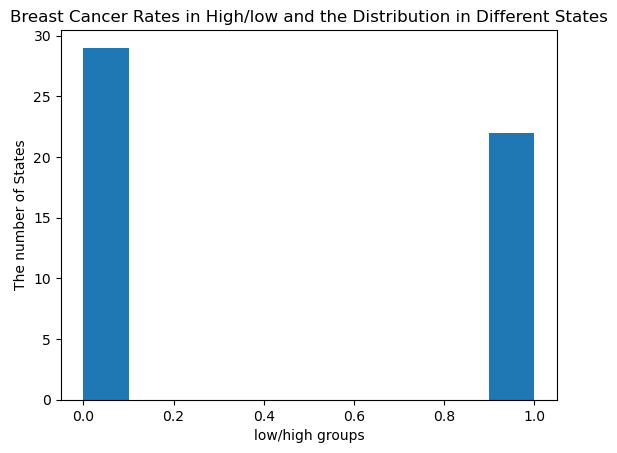

In [23]:
plt.hist(df_cancer_clusters[df_cancer_clusters['Leading Cancer Sites']=='Breast']['cluster'])
plt.title('Breast Cancer Rates in High/low and the Distribution in Different States')
plt.xlabel('low/high groups')
plt.ylabel('The number of States')
plt.show()

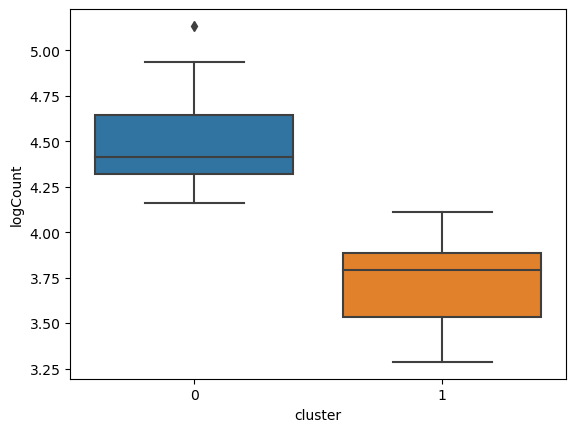

In [24]:
sns.boxplot(x='cluster', y='logCount', data=df_cancer_clusters[df_cancer_clusters['Leading Cancer Sites']=='Breast']);


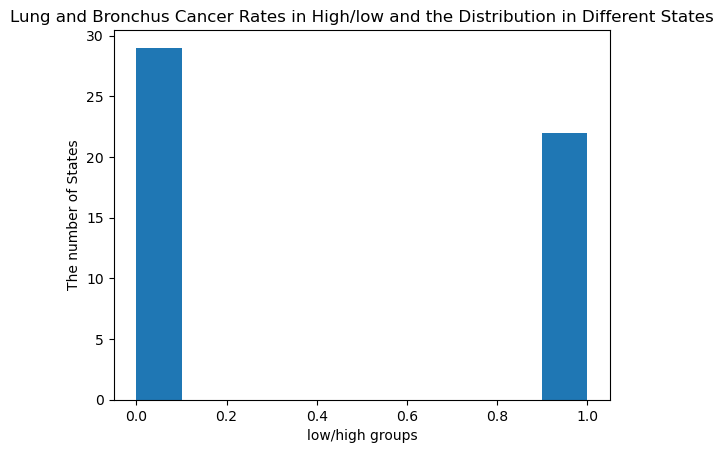

In [25]:
plt.hist(df_cancer_clusters[df_cancer_clusters['Leading Cancer Sites']=='Breast']['cluster'],label='Lung and Bronchus Cancer Rates in High/low and the Distribution in Different States')
plt.title('Lung and Bronchus Cancer Rates in High/low and the Distribution in Different States')
plt.xlabel('low/high groups')
plt.ylabel('The number of States')
plt.show()

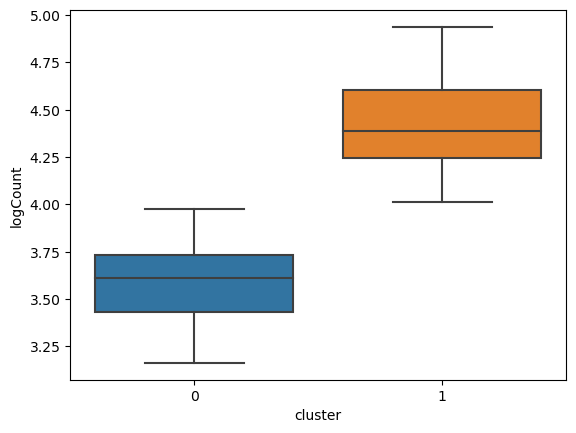

In [26]:
sns.boxplot(x='cluster', y='logCount', data=df_cancer_clusters[df_cancer_clusters['Leading Cancer Sites']=='Lung and Bronchus']);


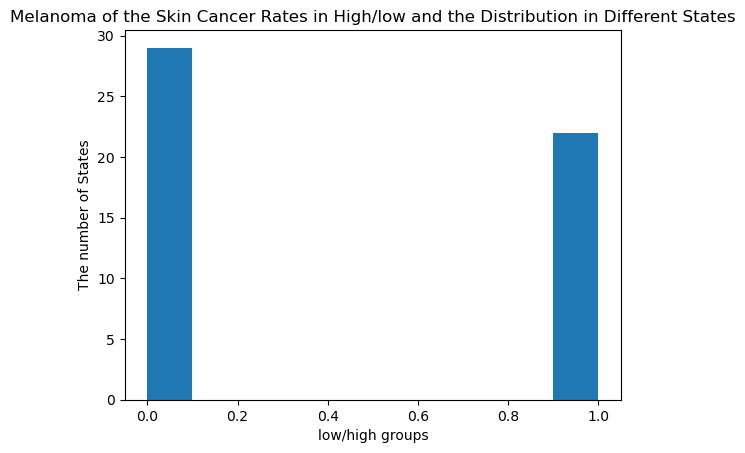

In [27]:
plt.hist(df_cancer_clusters[df_cancer_clusters['Leading Cancer Sites']=='Breast']['cluster'],label='Melanoma of the Skin Cancer Rates in High/low and the Distribution in Different States')
plt.title('Melanoma of the Skin Cancer Rates in High/low and the Distribution in Different States')
plt.xlabel('low/high groups')
plt.ylabel('The number of States')
plt.show()

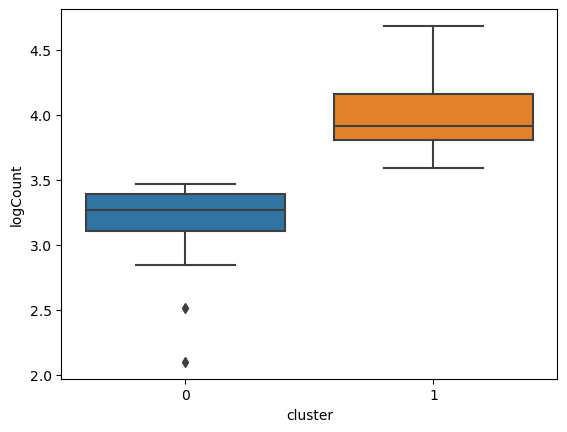

In [28]:
sns.boxplot(x='cluster', y='logCount', data=df_cancer_clusters[df_cancer_clusters['Leading Cancer Sites']=='Melanoma of the Skin']);


# Investigation of correlation between cancer rates and the provided features

In [29]:
df_cdc_smoking = pd.read_csv('data/cdc_smoking_data.csv')
df_cancer_clean = pd.read_csv('data/cancer_clean.csv')

In [30]:
df_lung_smoking = pd.merge( \
                             df_cdc_smoking,
        #df_cdc_smoking[['year','locationdesc','gender','topicdesc','measuredesc','response','data_value','data_value_footnote_symbol']], \
        df_cancer_clean[df_cancer_clean['Leading Cancer Sites']=='Lung and Bronchus'], \
        left_on = ['year','locationdesc','gender'], \
        right_on = ['Year','States','Sex'])
df_lung_smoking.head()

,year,locationabbr,locationdesc,topictype,topicdesc,measuredesc,response,data_value_unit,data_value,gender,...,Leading Cancer Sites,Leading Cancer Sites Code,States,States Code,Year,Year Code,Sex,Sex Code,Count,age_group
0,2018,AL,Alabama,Tobacco Use – Survey Data,Cigarette Use (Adults),Smoking Frequency,Every Day,%,62.2,Male,...,Lung and Bronchus,22030,Alabama,1,2018,2018,Male,M,20,25 to 44
1,2018,AL,Alabama,Tobacco Use – Survey Data,Cigarette Use (Adults),Smoking Frequency,Every Day,%,62.2,Male,...,Lung and Bronchus,22030,Alabama,1,2018,2018,Male,M,725,45 to 64
2,2018,AL,Alabama,Tobacco Use – Survey Data,Cigarette Use (Adults),Smoking Frequency,Every Day,%,62.2,Male,...,Lung and Bronchus,22030,Alabama,1,2018,2018,Male,M,1462,65+
3,2018,AL,Alabama,Tobacco Use – Survey Data,Cigarette Use (Adults),Smoking Status,Current,%,21.3,Male,...,Lung and Bronchus,22030,Alabama,1,2018,2018,Male,M,20,25 to 44
4,2018,AL,Alabama,Tobacco Use – Survey Data,Cigarette Use (Adults),Smoking Status,Current,%,21.3,Male,...,Lung and Bronchus,22030,Alabama,1,2018,2018,Male,M,725,45 to 64


In [31]:
df_lung_smoking.columns

Index(['year', 'locationabbr', 'locationdesc', 'topictype', 'topicdesc',
       'measuredesc', 'response', 'data_value_unit', 'data_value', 'gender',
       'data_value_footnote_symbol', 'data_value_footnote',
       'Leading Cancer Sites', 'Leading Cancer Sites Code', 'States',
       'States Code', 'Year', 'Year Code', 'Sex', 'Sex Code', 'Count',
       'age_group'],
      dtype='object')

In [32]:
df_lung_smoking['check'] = df_lung_smoking[['data_value_footnote_symbol','Count']].apply(lambda s: False if str(s[0])=='*' or s[1]<0 else True, axis=1)
df_lung_smoking = df_lung_smoking[df_lung_smoking['check']]

df_lung_smoking = df_lung_smoking[['Year', 'States', 'Sex', 'Count','topicdesc', \
       'measuredesc', 'response', 'data_value','age_group']].drop_duplicates()
df_lung_smoking.to_csv('data/cancer_lung_smoking.csv', index=False)
df_lung_smoking.shape

(16578, 9)

## 2. Predict Lung Cancer with CDC Smoking Survey

### Data Description and Correlation Description

In [33]:
df_lung_smoking = pd.read_csv('data/cancer_lung_smoking.csv')

encoder = LabelEncoder()
for c in ['measuredesc', 'response','Sex','topicdesc','age_group']:
    df_lung_smoking[c] = encoder.fit_transform(df_lung_smoking[[c]])

df_lung_smoking.describe()

/Users/lucy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

,Year,Sex,Count,topicdesc,measuredesc,response,data_value,age_group
count,16578.000000,16578.000000,16578.000000,16578.000000,16578.000000,16578.000000,16578.000000,16578.000000
mean,2016.203764,0.532211,736.469297,0.837857,1.728556,2.252262,42.960641,1.000000
std,1.342879,0.498976,1128.104115,0.857042,1.129128,1.828686,28.591998,0.816521
min,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000
25%,2015.000000,0.000000,30.000000,0.000000,1.000000,1.000000,19.300000,0.000000
50%,2016.000000,1.000000,280.500000,1.000000,2.000000,2.000000,36.650000,1.000000
75%,2017.000000,1.000000,999.000000,2.000000,3.000000,4.000000,66.600000,2.000000
max,2018.000000,1.000000,6708.000000,2.000000,3.000000,5.000000,99.800000,2.000000


In [34]:
features = ['Count', 'measuredesc', 'response','Sex','topicdesc','age_group','data_value']
df_lung_smoking[features].corr()

,Count,measuredesc,response,Sex,topicdesc,age_group,data_value
Count,1.000000,-1.391013e-02,3.719787e-03,1.805923e-02,9.961602e-03,5.516971e-01,2.269274e-03
measuredesc,-0.013910,1.000000e+00,-2.816604e-01,-9.883157e-02,9.888948e-02,1.342806e-17,-1.343093e-01
response,0.003720,-2.816604e-01,1.000000e+00,2.639767e-02,4.041803e-02,-1.273843e-18,5.040324e-01
Sex,0.018059,-9.883157e-02,2.639767e-02,1.000000e+00,8.711802e-02,2.279992e-17,1.591025e-02
topicdesc,0.009962,9.888948e-02,4.041803e-02,8.711802e-02,1.000000e+00,-2.294049e-17,1.417369e-01
age_group,0.551697,1.342806e-17,-1.273843e-18,2.279992e-17,-2.294049e-17,1.000000e+00,-4.039196e-19
data_value,0.002269,-1.343093e-01,5.040324e-01,1.591025e-02,1.417369e-01,-4.039196e-19,1.000000e+00


In [35]:
from sklearn.cluster import KMeans

Xt = np.array(df_lung_smoking[['Count']],dtype=np.float128).reshape(-1,1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(Xt)
df_lung_smoking['cluster'] = kmeans.predict(Xt)
df_lung_smoking.to_csv('data/cancer_lung_smoking_clusters.csv',index=False)
df_lung_smoking.head()

/Users/lucy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Year,States,Sex,Count,topicdesc,measuredesc,response,data_value,age_group,cluster
0,2018,Alabama,1,20,0,1,1,62.2,0,0
1,2018,Alabama,1,725,0,1,1,62.2,1,0
2,2018,Alabama,1,1462,0,1,1,62.2,2,0
3,2018,Alabama,1,20,0,2,0,21.3,0,0
4,2018,Alabama,1,725,0,2,0,21.3,1,0


In [36]:
features = ['Count', 'measuredesc', 'response','Sex','topicdesc','age_group','data_value','cluster']
df_lung_smoking[features].corr()

,Count,measuredesc,response,Sex,topicdesc,age_group,data_value,cluster
Count,1.000000,-1.391013e-02,3.719787e-03,1.805923e-02,9.961602e-03,5.516971e-01,2.269274e-03,0.797689
measuredesc,-0.013910,1.000000e+00,-2.816604e-01,-9.883157e-02,9.888948e-02,1.342806e-17,-1.343093e-01,-0.009864
response,0.003720,-2.816604e-01,1.000000e+00,2.639767e-02,4.041803e-02,-1.273843e-18,5.040324e-01,0.002621
Sex,0.018059,-9.883157e-02,2.639767e-02,1.000000e+00,8.711802e-02,2.279992e-17,1.591025e-02,0.013519
topicdesc,0.009962,9.888948e-02,4.041803e-02,8.711802e-02,1.000000e+00,-2.294049e-17,1.417369e-01,0.007549
age_group,0.551697,1.342806e-17,-1.273843e-18,2.279992e-17,-2.294049e-17,1.000000e+00,-4.039196e-19,0.376901
data_value,0.002269,-1.343093e-01,5.040324e-01,1.591025e-02,1.417369e-01,-4.039196e-19,1.000000e+00,0.001473
cluster,0.797689,-9.863619e-03,2.620898e-03,1.351917e-02,7.549114e-03,3.769012e-01,1.472851e-03,1.000000


### Data Modeling with smoking and cancer features

In [37]:
from sklearn import preprocessing
cat_col = ['measuredesc', 'response','Sex','topicdesc','age_group']
data_df = df_lung_smoking.copy()
label_encoder = preprocessing.LabelEncoder()
for c in cat_col:
    data_df[c+'_label']= label_encoder.fit_transform(data_df[c])
#oh_encoder = preprocessing.OneHotEncoder()
oh_encoder = preprocessing.OneHotEncoder(categories='auto') 
np_labels = oh_encoder.fit_transform(data_df[[c+'_label' for c in cat_col]]).toarray()
data_df = pd.concat([data_df, pd.DataFrame(np_labels)],axis=1)
data_df = data_df.drop(cat_col+[c+'_label' for c in cat_col]+['Year','States'], axis=1)
data_df.head()

,Count,data_value,cluster,0,1,2,3,4,5,6,...,8,9,10,11,12,13,14,15,16,17
0,20,62.2,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,725,62.2,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1462,62.2,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,20,21.3,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,725,21.3,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [39]:
df_positive = data_df[data_df['cluster']==1]
df_negative = data_df[data_df['cluster']==0]
df_positive.shape, df_negative.shape

((2243, 21), (14335, 21))

In [40]:
train_df = pd.concat([df_positive[:1000],df_negative[:1000]])
test_df = pd.concat([df_positive[-1000:],df_negative[1000:2000]])

In [41]:
train_df.head(10)

,Count,data_value,cluster,0,1,2,3,4,5,6,...,8,9,10,11,12,13,14,15,16,17
1291,1987,55.1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1292,6043,55.1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1294,1987,96.9,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1295,6043,96.9,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1297,1987,3.1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1298,6043,3.1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1300,1987,14.8,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1301,6043,14.8,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1303,1987,26.3,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1304,6043,26.3,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [42]:
test_df.head(10)

,Count,data_value,cluster,0,1,2,3,4,5,6,...,8,9,10,11,12,13,14,15,16,17
10456,2044,10.9,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
10457,5317,10.9,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10459,2044,1.1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10460,5317,1.1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
10462,2044,11.8,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
10463,5317,11.8,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
10465,2044,70.2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10466,5317,70.2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
10468,2044,86.2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
10469,5317,86.2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [43]:

def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])
    
    return (train,test)

In [44]:
def performance_assessment(predictions_df, output_feature='Returned', 
                           prediction_feature='predictions'):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])

    performances = performances.round(3)
    
    return performances



def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test'):

    performances=[]
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions_df, output_feature=output_feature, \
                                                   prediction_feature='predictions')
        performances_model.index=[classifier_name]
        
        #performances=performances.append(performances_model)
        performances.append(performances_model)
    return pd.concat(performances) 

In [45]:
fitted_models_and_predictions_dictionary={}
input_features = [str(c) for c in data_df.columns if c!='cluster']
output_feature = 'cluster'
train_df.columns = [str(c) for c in train_df.columns]
test_df.columns = [str(c) for c in test_df.columns]

In [46]:

import sklearn
from sklearn import *

import warnings
warnings.filterwarnings('ignore')


IR=1.0/1.0
IR=1.0/1.0

class_weight={0:IR,1:1.0}

classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'Decision tree with depth of two': sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight=class_weight,random_state=0),
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(class_weight=class_weight,random_state=0), 
                        'Random forest':sklearn.ensemble.RandomForestClassifier(class_weight=class_weight,random_state=0,n_jobs=-1),
                        
                       }


for classifier_name in classifiers_dictionary:
    
    (train_df, test_df)=scaleData(train_df,test_df,input_features)
    
    classifier = classifiers_dictionary[classifier_name]
    classifier.fit(train_df[input_features], train_df[output_feature])

    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train
                                       }
    
    fitted_models_and_predictions_dictionary[classifier_name] = model_and_predictions_dictionary


In [47]:
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, test_df, 
                                                        type_set='test')
df_performances

,AUC ROC,Average precision
Logistic regression,1.0,1.0
Decision tree with depth of two,1.0,1.0
Decision tree - unlimited depth,1.0,1.0
Random forest,1.0,1.0


### Insights and Visualization: for 'measuredesc', 'response','Sex','topicdesc','age_group','data_value'

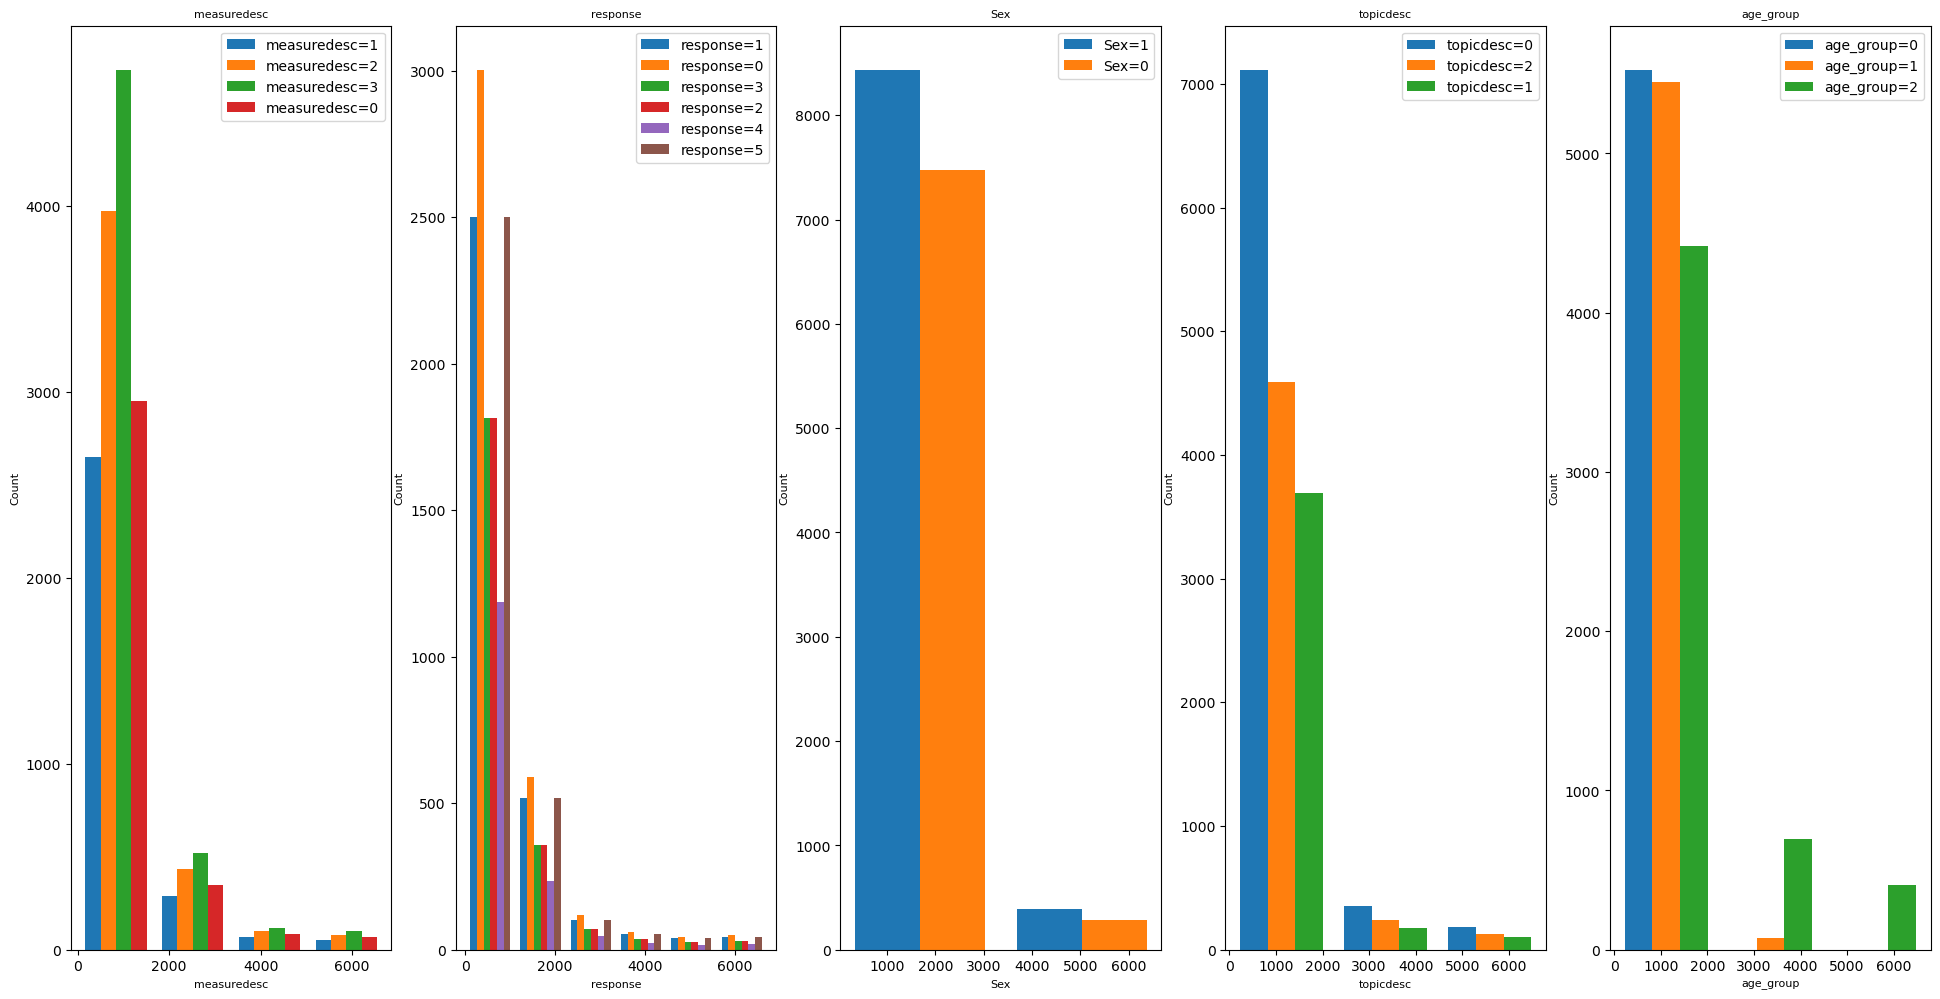

In [48]:
features = ['Count', 'measuredesc', 'response','Sex','topicdesc','age_group','data_value']
cat_col = ['measuredesc', 'response','Sex','topicdesc','age_group']

index = 0
fig, axs = plt.subplots(1, 5,figsize=(24, 12))
fontsize = 8

for ax in axs.flat:
    column = cat_col[index]
    df = df_lung_smoking.copy()       
    ax.hist([df[df[column]==v]['Count'] for v in df[column].unique()],bins=len(df[column].unique()),label=[column +'='+str(v) for v in df[column].unique()])
    ax.set_xlabel(column, fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_title(column, fontsize=fontsize)
    ax.legend()
    index = index + 1

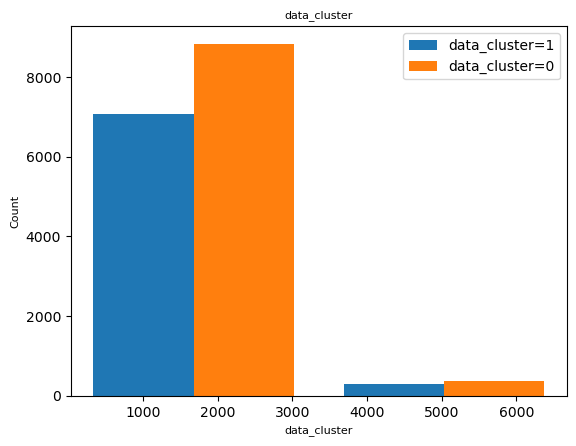

In [49]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(df_lung_smoking[['data_value']])
df_lung_smoking['data_cluster'] = kmeans.predict(df_lung_smoking[['data_value']])
column = 'data_cluster'
df = df_lung_smoking.copy()
plt.hist([df[df[column]==v]['Count'] for v in df[column].unique()],bins=len(df[column].unique()),label=[column +'='+str(v) for v in df[column].unique()])
plt.xlabel(column, fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.title(column, fontsize=fontsize)
plt.legend()

## 3. The effect of Population and Economic_Indicators for Three Cancer Types

### Preprocessing

In [51]:
df_population = pd.read_csv('data/population.csv')
df_economic_indicators = pd.read_csv('data/economic_indicators.csv')
df_cancer_clean = pd.read_csv('data/cancer_clean.csv')

In [52]:
print('check missing values in population')
print(df_population.shape)

for c in df_population.columns:
    print(c, df_population.shape[0], df_population.dropna(subset=[c]).shape[0])
df_population.head()

check missing values in population
(5610, 5)
fips 5610 5610
year 5610 5610
sex 5610 5610
age_group 5610 5610
population 5610 5610


,fips,year,sex,age_group,population
0,1,2010,Female,18 to 25,238765.0
1,1,2010,Female,25 to 44,622989.0
2,1,2010,Female,45 to 64,664491.0
3,1,2010,Female,65+,2840671.0
4,1,2010,Female,Under 18,552908.0


In [53]:
print('check missing values in economic_indicators')
print(df_economic_indicators.shape)

for c in df_economic_indicators.columns:
    print(c, df_economic_indicators.shape[0], df_economic_indicators.dropna(subset=[c]).shape[0])
print('after dropping missing values, ',df_economic_indicators.dropna().shape)

check missing values in economic_indicators
(1248, 12)
fips 1248 1248
year 1248 1248
real_gdp 1248 1248
real_personal_income 1248 676
real_pce 1248 676
gdp 1248 1248
personal_income 1248 1248
disposable_personal_income 1248 1248
pce 1248 1196
regional_price_parities 1248 676
n_jobs 1248 1248
regional_price_deflator 1248 663
after dropping missing values,  (663, 12)


In [54]:
df_economic_indicators = df_economic_indicators.dropna()

In [55]:
df_economic_indicators.head()

,fips,year,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator
34,1000,2008,186946.7,187336.6,154136.2,174526.3,158450.6,142497.3,130497.7,89.757,2582591.0,84.664
35,1000,2009,180707.2,187152.4,154251.7,170930.9,155913.5,143477.6,128675.8,88.685,2479507.0,83.419
36,1000,2010,184702.4,187279.9,152978.9,177249.2,162531.1,149324.4,132956.3,90.772,2460298.0,86.912
37,1000,2011,187605.8,189172.7,154000.3,183916.6,168474.3,153427.5,137347.4,90.849,2497933.0,89.186
38,1000,2012,189245.5,190450.8,153964.4,189245.5,173361.7,158534.0,140347.7,91.156,2503678.0,91.156


In [56]:
df_economic_indicators['fips'].unique()

array([ 1000,  2000,  4000,  5000,  6000,  8000,  9000, 10000, 11000,
       12000, 13000, 15000, 16000, 17000, 18000, 19000, 20000, 21000,
       22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000,
       31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000,
       40000, 41000, 42000, 44000, 45000, 46000, 47000, 48000, 49000,
       50000, 51000, 53000, 54000, 55000, 56000])

In [57]:
df_population['fips'].unique()

array([ 1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56])

In [58]:
df_population.shape

(5610, 5)

In [59]:
df_economic_indicators['fips_convert'] = df_economic_indicators['fips'].apply(lambda t: int(t*0.001))
df_economic_indicators['fips_convert'].unique()

array([ 1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56])

In [60]:
df_eco = pd.merge(df_population, df_economic_indicators, left_on=['fips','year'], right_on=['fips_convert','year'], how='left')
df_eco.to_csv('data/economic_population.csv',index=False)
df_eco.shape

(5610, 17)

In [61]:
df_eco.head()

,fips_x,year,sex,age_group,population,fips_y,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator,fips_convert
0,1,2010,Female,18 to 25,238765.0,1000,184702.4,187279.9,152978.9,177249.2,162531.1,149324.4,132956.3,90.772,2460298.0,86.912,1
1,1,2010,Female,25 to 44,622989.0,1000,184702.4,187279.9,152978.9,177249.2,162531.1,149324.4,132956.3,90.772,2460298.0,86.912,1
2,1,2010,Female,45 to 64,664491.0,1000,184702.4,187279.9,152978.9,177249.2,162531.1,149324.4,132956.3,90.772,2460298.0,86.912,1
3,1,2010,Female,65+,2840671.0,1000,184702.4,187279.9,152978.9,177249.2,162531.1,149324.4,132956.3,90.772,2460298.0,86.912,1
4,1,2010,Female,Under 18,552908.0,1000,184702.4,187279.9,152978.9,177249.2,162531.1,149324.4,132956.3,90.772,2460298.0,86.912,1


In [62]:
df_cancer_eco = pd.merge(df_cancer_clean, df_eco, left_on=['Year','Sex','age_group'], right_on=['year','sex','age_group'],how='left')
df_cancer_eco.shape

(234090, 26)

In [63]:
df_cancer_eco.columns

Index(['Leading Cancer Sites', 'Leading Cancer Sites Code', 'States',
       'States Code', 'Year', 'Year Code', 'Sex', 'Sex Code', 'Count',
       'age_group', 'fips_x', 'year', 'sex', 'population', 'fips_y',
       'real_gdp', 'real_personal_income', 'real_pce', 'gdp',
       'personal_income', 'disposable_personal_income', 'pce',
       'regional_price_parities', 'n_jobs', 'regional_price_deflator',
       'fips_convert'],
      dtype='object')

In [64]:
df_cancer_eco = df_cancer_eco[['Leading Cancer Sites', 'States',
       'Year', 'Sex', 'Count','age_group', 'population',
       'real_gdp', 'real_personal_income', 'real_pce', 'gdp',
       'personal_income', 'disposable_personal_income', 'pce',
       'regional_price_parities', 'n_jobs', 'regional_price_deflator']]
df_cancer_eco.to_csv('data/cancer_eco.csv',index=False)


### Data Description and Correlation Description

In [101]:
df_cancer_eco = pd.read_csv('data/cancer_eco.csv')


df_cancer_eco[['Count', 'population', \
       'real_gdp', 'real_personal_income', 'real_pce', 'gdp',
       'personal_income', 'disposable_personal_income', 'pce', \
       'regional_price_parities', 'n_jobs', 'regional_price_deflator']].describe()

,Count,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator
count,234090.000000,2.340900e+05,2.340900e+05,2.340900e+05,2.340900e+05,2.340900e+05,2.340900e+05,2.340900e+05,2.340900e+05,234090.000000,2.340900e+05,234090.000000
mean,605.320261,1.762176e+06,3.446969e+05,3.035915e+05,2.387719e+05,3.682133e+05,3.186348e+05,2.802172e+05,2.506564e+05,97.726780,3.790827e+06,102.515522
std,1215.169607,2.809898e+06,4.347509e+05,3.508248e+05,2.683428e+05,4.625618e+05,3.907579e+05,3.380391e+05,2.983876e+05,6.291189,4.243836e+06,6.846077
min,0.000000,7.056100e+04,2.891220e+04,2.989550e+04,2.241500e+04,3.009940e+04,3.019590e+04,2.715850e+04,2.255350e+04,87.185000,3.981300e+05,91.956000
25%,24.000000,3.674900e+05,7.894740e+04,7.298060e+04,6.180150e+04,8.721740e+04,7.454280e+04,6.632610e+04,6.233090e+04,92.779000,9.211230e+05,96.915000
50%,143.000000,7.947260e+05,1.974532e+05,2.014254e+05,1.578226e+05,2.113059e+05,1.943641e+05,1.736531e+05,1.590719e+05,96.631000,2.519975e+06,101.234000
75%,603.000000,1.798220e+06,4.523252e+05,3.942625e+05,3.020626e+05,4.831913e+05,4.110198e+05,3.604804e+05,3.271788e+05,101.517000,4.631417e+06,107.040000
max,12777.000000,2.293998e+07,2.644061e+06,2.031413e+06,1.530106e+06,2.897201e+06,2.431774e+06,2.078193e+06,1.835635e+06,113.385000,2.407814e+07,120.138000


In [100]:
df_cancer_eco[['Count', 'population',
       'real_gdp', 'real_personal_income', 'real_pce', 'gdp',
       'personal_income', 'disposable_personal_income', 'pce',
       'regional_price_parities', 'n_jobs', 'regional_price_deflator']].corr()

,Count,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator
Count,1.000000,0.121110,0.000137,0.000194,0.000187,0.000218,0.000246,0.000246,0.000243,-0.000112,0.000124,0.001101
population,0.121110,1.000000,0.694707,0.703457,0.705372,0.692927,0.698358,0.700608,0.701898,0.211061,0.705495,0.205915
real_gdp,0.000137,0.694707,1.000000,0.993469,0.985562,0.998863,0.995295,0.994701,0.990330,0.375472,0.989594,0.370011
real_personal_income,0.000194,0.703457,0.993469,1.000000,0.997802,0.992796,0.997234,0.998534,0.997665,0.339417,0.997922,0.337128
real_pce,0.000187,0.705372,0.985562,0.997802,1.000000,0.984828,0.992501,0.994938,0.997062,0.321514,0.998085,0.319969
gdp,0.000218,0.692927,0.998863,0.992796,0.984828,1.000000,0.996410,0.995046,0.991385,0.382235,0.987308,0.382015
personal_income,0.000246,0.698358,0.995295,0.997234,0.992501,0.996410,1.000000,0.999465,0.998053,0.375817,0.992009,0.376561
disposable_personal_income,0.000246,0.700608,0.994701,0.998534,0.994938,0.995046,0.999465,1.000000,0.998610,0.363854,0.994757,0.365605
pce,0.000243,0.701898,0.990330,0.997665,0.997062,0.991385,0.998053,0.998610,1.000000,0.360342,0.994676,0.361953
regional_price_parities,-0.000112,0.211061,0.375472,0.339417,0.321514,0.382235,0.375817,0.363854,0.360342,1.000000,0.317662,0.956611


### Data Modeling: Cancer Rate Prediction with Population and Economic Features

In [65]:
df_cancer_eco = pd.read_csv('data/cancer_eco.csv')
df_cancer_eco.head()

,Leading Cancer Sites,States,Year,Sex,Count,age_group,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator
0,Breast,Alabama,2014,Female,359,25 to 44,625968.0,189886.3,193661.1,158801.9,197406.9,181078.8,164562.8,148689.4,91.005,2551872.0,93.632
1,Breast,Alabama,2014,Female,359,25 to 44,96452.0,54188.2,38785.7,30847.5,56484.9,41210.0,37647.8,32820.9,103.412,461327.0,106.397
2,Breast,Alabama,2014,Female,359,25 to 44,851477.0,276948.9,255373.4,224210.8,287666.6,257272.3,232184.1,226189.9,98.052,3448173.0,100.883
3,Breast,Alabama,2014,Female,359,25 to 44,375254.0,111734.5,124218.9,95551.4,116139.4,114743.3,103942.3,88384.5,89.904,1587414.0,92.499
4,Breast,Alabama,2014,Female,359,25 to 44,5326265.0,2256054.7,1779397.6,1355802.4,2335286.5,1980736.8,1704446.4,1511296.2,108.341,21997098.0,111.469


### Breast Cancer Rates Prediction and Insights Visualization

In [66]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = data.values #scaler.fit_transform(data.values)
    df = pd.DataFrame(scaled)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

features = ['Count','population',
       'real_gdp', 'real_personal_income', 'real_pce', 'gdp',
       'personal_income', 'disposable_personal_income', 'pce',
       'regional_price_parities', 'n_jobs', 'regional_price_deflator']

df_cancer_shift = []
for k, g in df_cancer_eco[df_cancer_eco['Leading Cancer Sites']=='Breast'].groupby(['States','age_group','Sex']):
    
    r = series_to_supervised(g[features], n_in=1, n_out=1, dropnan=True)
    r = r.drop(r.columns[[i for i in range(len(features)+1, len(features)*2)]],axis=1)
    
    df_cancer_shift.append(r.values)
    

In [67]:
  
# split into train and test sets
values = np.array(df_cancer_shift)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values.reshape(-1,13))
values = scaled.reshape(-1,254,13)


In [68]:
n_train_hours = int(values.shape[0]*0.67)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:,:, :-1], train[:,:, -1]
test_X, test_y = test[:,:, :-1], test[:,:, -1]
train_X.shape, train_y.shape

((205, 254, 12), (205, 254))

In [69]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape(-1,12).reshape((-1, 1, 12))
test_X = test_X.reshape(-1,12).reshape((-1, 1, 12))
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 

(52070, 1, 12) (52070, 1) (25654, 1, 12) (25654, 1)


In [70]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)



Epoch 1/500
724/724 - 7s - loss: 0.0293 - val_loss: 0.0041 - 7s/epoch - 9ms/step
Epoch 2/500
724/724 - 3s - loss: 0.0039 - val_loss: 0.0034 - 3s/epoch - 4ms/step
Epoch 3/500
724/724 - 3s - loss: 0.0031 - val_loss: 0.0030 - 3s/epoch - 4ms/step
Epoch 4/500
724/724 - 3s - loss: 0.0029 - val_loss: 0.0039 - 3s/epoch - 4ms/step
Epoch 5/500
724/724 - 3s - loss: 0.0031 - val_loss: 0.0020 - 3s/epoch - 4ms/step
Epoch 6/500
724/724 - 3s - loss: 0.0027 - val_loss: 0.0055 - 3s/epoch - 4ms/step
Epoch 7/500
724/724 - 3s - loss: 0.0028 - val_loss: 0.0030 - 3s/epoch - 4ms/step
Epoch 8/500
724/724 - 3s - loss: 0.0031 - val_loss: 0.0018 - 3s/epoch - 4ms/step
Epoch 9/500
724/724 - 3s - loss: 0.0025 - val_loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 10/500
724/724 - 3s - loss: 0.0025 - val_loss: 0.0063 - 3s/epoch - 4ms/step
Epoch 11/500
724/724 - 3s - loss: 0.0020 - val_loss: 0.0032 - 3s/epoch - 4ms/step
Epoch 12/500
724/724 - 3s - loss: 0.0027 - val_loss: 0.0026 - 3s/epoch - 4ms/step
Epoch 13/500
724/724 - 3s

Epoch 101/500
724/724 - 3s - loss: 0.0023 - val_loss: 0.0019 - 3s/epoch - 4ms/step
Epoch 102/500
724/724 - 3s - loss: 0.0019 - val_loss: 0.0025 - 3s/epoch - 4ms/step
Epoch 103/500
724/724 - 3s - loss: 0.0022 - val_loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 104/500
724/724 - 3s - loss: 0.0024 - val_loss: 0.0031 - 3s/epoch - 4ms/step
Epoch 105/500
724/724 - 3s - loss: 0.0023 - val_loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 106/500
724/724 - 3s - loss: 0.0021 - val_loss: 0.0031 - 3s/epoch - 4ms/step
Epoch 107/500
724/724 - 3s - loss: 0.0021 - val_loss: 0.0012 - 3s/epoch - 4ms/step
Epoch 108/500
724/724 - 3s - loss: 0.0022 - val_loss: 0.0046 - 3s/epoch - 4ms/step
Epoch 109/500
724/724 - 3s - loss: 0.0022 - val_loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 110/500
724/724 - 3s - loss: 0.0019 - val_loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 111/500
724/724 - 3s - loss: 0.0021 - val_loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 112/500
724/724 - 3s - loss: 0.0020 - val_loss: 0.0049 - 3s/epoch - 4ms/step
Epoc

Epoch 200/500
724/724 - 3s - loss: 0.0015 - val_loss: 0.0013 - 3s/epoch - 4ms/step
Epoch 201/500
724/724 - 3s - loss: 0.0015 - val_loss: 0.0013 - 3s/epoch - 4ms/step
Epoch 202/500
724/724 - 3s - loss: 0.0015 - val_loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 203/500
724/724 - 3s - loss: 0.0015 - val_loss: 0.0017 - 3s/epoch - 4ms/step
Epoch 204/500
724/724 - 3s - loss: 0.0015 - val_loss: 0.0013 - 3s/epoch - 4ms/step
Epoch 205/500
724/724 - 3s - loss: 0.0017 - val_loss: 0.0021 - 3s/epoch - 4ms/step
Epoch 206/500
724/724 - 3s - loss: 0.0014 - val_loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 207/500
724/724 - 3s - loss: 0.0017 - val_loss: 0.0020 - 3s/epoch - 4ms/step
Epoch 208/500
724/724 - 3s - loss: 0.0016 - val_loss: 0.0019 - 3s/epoch - 4ms/step
Epoch 209/500
724/724 - 3s - loss: 0.0016 - val_loss: 0.0017 - 3s/epoch - 4ms/step
Epoch 210/500
724/724 - 3s - loss: 0.0015 - val_loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 211/500
724/724 - 3s - loss: 0.0016 - val_loss: 6.0026e-04 - 3s/epoch - 4ms/step


Epoch 298/500
724/724 - 3s - loss: 0.0013 - val_loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 299/500
724/724 - 3s - loss: 0.0011 - val_loss: 0.0018 - 3s/epoch - 4ms/step
Epoch 300/500
724/724 - 3s - loss: 0.0013 - val_loss: 0.0012 - 3s/epoch - 4ms/step
Epoch 301/500
724/724 - 3s - loss: 0.0012 - val_loss: 0.0018 - 3s/epoch - 4ms/step
Epoch 302/500
724/724 - 3s - loss: 0.0013 - val_loss: 0.0018 - 3s/epoch - 4ms/step
Epoch 303/500
724/724 - 3s - loss: 0.0014 - val_loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 304/500
724/724 - 3s - loss: 0.0014 - val_loss: 0.0013 - 3s/epoch - 4ms/step
Epoch 305/500
724/724 - 3s - loss: 0.0012 - val_loss: 0.0017 - 3s/epoch - 4ms/step
Epoch 306/500
724/724 - 3s - loss: 0.0013 - val_loss: 0.0018 - 3s/epoch - 4ms/step
Epoch 307/500
724/724 - 3s - loss: 0.0012 - val_loss: 4.2277e-04 - 3s/epoch - 4ms/step
Epoch 308/500
724/724 - 3s - loss: 0.0014 - val_loss: 0.0013 - 3s/epoch - 4ms/step
Epoch 309/500
724/724 - 3s - loss: 0.0012 - val_loss: 0.0018 - 3s/epoch - 4ms/step


Epoch 396/500
724/724 - 3s - loss: 0.0014 - val_loss: 0.0020 - 3s/epoch - 4ms/step
Epoch 397/500
724/724 - 3s - loss: 0.0011 - val_loss: 4.5177e-04 - 3s/epoch - 4ms/step
Epoch 398/500
724/724 - 3s - loss: 0.0012 - val_loss: 6.9537e-04 - 3s/epoch - 4ms/step
Epoch 399/500
724/724 - 3s - loss: 0.0011 - val_loss: 0.0018 - 3s/epoch - 4ms/step
Epoch 400/500
724/724 - 3s - loss: 0.0015 - val_loss: 0.0057 - 3s/epoch - 4ms/step
Epoch 401/500
724/724 - 3s - loss: 0.0013 - val_loss: 0.0022 - 3s/epoch - 4ms/step
Epoch 402/500
724/724 - 3s - loss: 0.0014 - val_loss: 0.0010 - 3s/epoch - 4ms/step
Epoch 403/500
724/724 - 3s - loss: 0.0010 - val_loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 404/500
724/724 - 3s - loss: 0.0012 - val_loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 405/500
724/724 - 3s - loss: 0.0011 - val_loss: 0.0022 - 3s/epoch - 4ms/step
Epoch 406/500
724/724 - 3s - loss: 0.0011 - val_loss: 0.0011 - 3s/epoch - 4ms/step
Epoch 407/500
724/724 - 3s - loss: 0.0012 - val_loss: 0.0022 - 3s/epoch - 4ms/s

Epoch 493/500
724/724 - 3s - loss: 0.0011 - val_loss: 9.8835e-04 - 3s/epoch - 4ms/step
Epoch 494/500
724/724 - 3s - loss: 0.0011 - val_loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 495/500
724/724 - 3s - loss: 0.0011 - val_loss: 0.0023 - 3s/epoch - 4ms/step
Epoch 496/500
724/724 - 3s - loss: 0.0013 - val_loss: 0.0017 - 3s/epoch - 4ms/step
Epoch 497/500
724/724 - 3s - loss: 0.0013 - val_loss: 5.4594e-04 - 3s/epoch - 4ms/step
Epoch 498/500
724/724 - 3s - loss: 0.0011 - val_loss: 7.6809e-04 - 3s/epoch - 4ms/step
Epoch 499/500
724/724 - 3s - loss: 0.0016 - val_loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 500/500
724/724 - 3s - loss: 0.0010 - val_loss: 0.0021 - 3s/epoch - 4ms/step


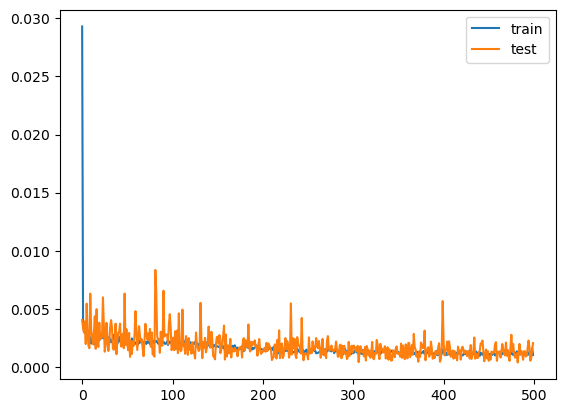

802/802 [==============================] - 3s 2ms/step
Test RMSE: 0.003


In [71]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# make a prediction
yhat = model.predict(test_X)
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_reshape[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [72]:
### Insights for Population, Economic_Indicators vs. Breast Cancer Rates

In [73]:
df_cancer_eco_norm = pd.DataFrame(values.reshape(-1,13), columns=features+['y_count'])
df_cancer_eco_norm.head()

,Count,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator,y_count
0,0.028097,0.024286,0.061554,0.081821,0.090461,0.058354,0.062827,0.066993,0.069570,0.145802,0.090952,0.059471,0.028097
1,0.028097,0.001132,0.009665,0.004442,0.005593,0.009203,0.004586,0.005114,0.005663,0.619351,0.002669,0.512419,0.028097
2,0.028097,0.034147,0.094846,0.112653,0.133844,0.089835,0.094553,0.099962,0.112315,0.414771,0.128802,0.316762,0.028097
3,0.028097,0.013323,0.031670,0.047126,0.048509,0.030009,0.035205,0.037437,0.036309,0.103779,0.050223,0.019268,0.028097
4,0.028097,0.229814,0.851631,0.874088,0.884391,0.804013,0.812191,0.817776,0.821112,0.807481,0.912118,0.692392,0.028097


In [74]:
df_cancer_eco_norm.describe()

,Count,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator,y_count
count,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000
mean,0.064143,0.074244,0.121214,0.137274,0.144063,0.118381,0.120569,0.123858,0.126301,0.402989,0.143836,0.374859,0.064157
std,0.132282,0.123030,0.166408,0.175421,0.178109,0.161491,0.162860,0.164963,0.164712,0.240384,0.179344,0.243388,0.132320
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.013034,0.019476,0.021542,0.026424,0.020812,0.018548,0.019831,0.022685,0.213511,0.022222,0.175963,0.000000
50%,0.005087,0.031866,0.064554,0.086123,0.090136,0.063778,0.069315,0.071739,0.075711,0.360763,0.090145,0.327620,0.005087
75%,0.060734,0.075683,0.161908,0.182045,0.185481,0.158031,0.158572,0.162514,0.168015,0.547023,0.178770,0.535235,0.060734
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
df_cancer_eco_norm.corr()

,Count,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator,y_count
Count,1.000000,0.074984,0.000270,0.000354,0.000352,0.000430,0.000467,0.000478,0.000471,-0.000226,0.000245,0.002230,0.999983
population,0.074984,1.000000,0.694251,0.703002,0.704919,0.692466,0.697902,0.700153,0.701442,0.209883,0.705042,0.205663,0.074908
real_gdp,0.000270,0.694251,1.000000,0.993462,0.985547,0.998861,0.995286,0.994692,0.990316,0.374313,0.989588,0.369905,0.000195
real_personal_income,0.000354,0.703002,0.993462,1.000000,0.997799,0.992787,0.997231,0.998533,0.997659,0.338088,0.997919,0.337006,0.000272
real_pce,0.000352,0.704919,0.985547,0.997799,1.000000,0.984809,0.992494,0.994934,0.997058,0.320095,0.998080,0.319836,0.000266
gdp,0.000430,0.692466,0.998861,0.992787,0.984809,1.000000,0.996404,0.995037,0.991371,0.381080,0.987294,0.381925,0.000354
personal_income,0.000467,0.697902,0.995286,0.997231,0.992494,0.996404,1.000000,0.999464,0.998050,0.374626,0.992001,0.376470,0.000389
disposable_personal_income,0.000478,0.700153,0.994692,0.998533,0.994934,0.995037,0.999464,1.000000,0.998608,0.362625,0.994753,0.365506,0.000399
pce,0.000471,0.701442,0.990316,0.997659,0.997058,0.991371,0.998050,0.998608,1.000000,0.359070,0.994666,0.361858,0.000390
regional_price_parities,-0.000226,0.209883,0.374313,0.338088,0.320095,0.381080,0.374626,0.362625,0.359070,1.000000,0.316239,0.957046,-0.000225


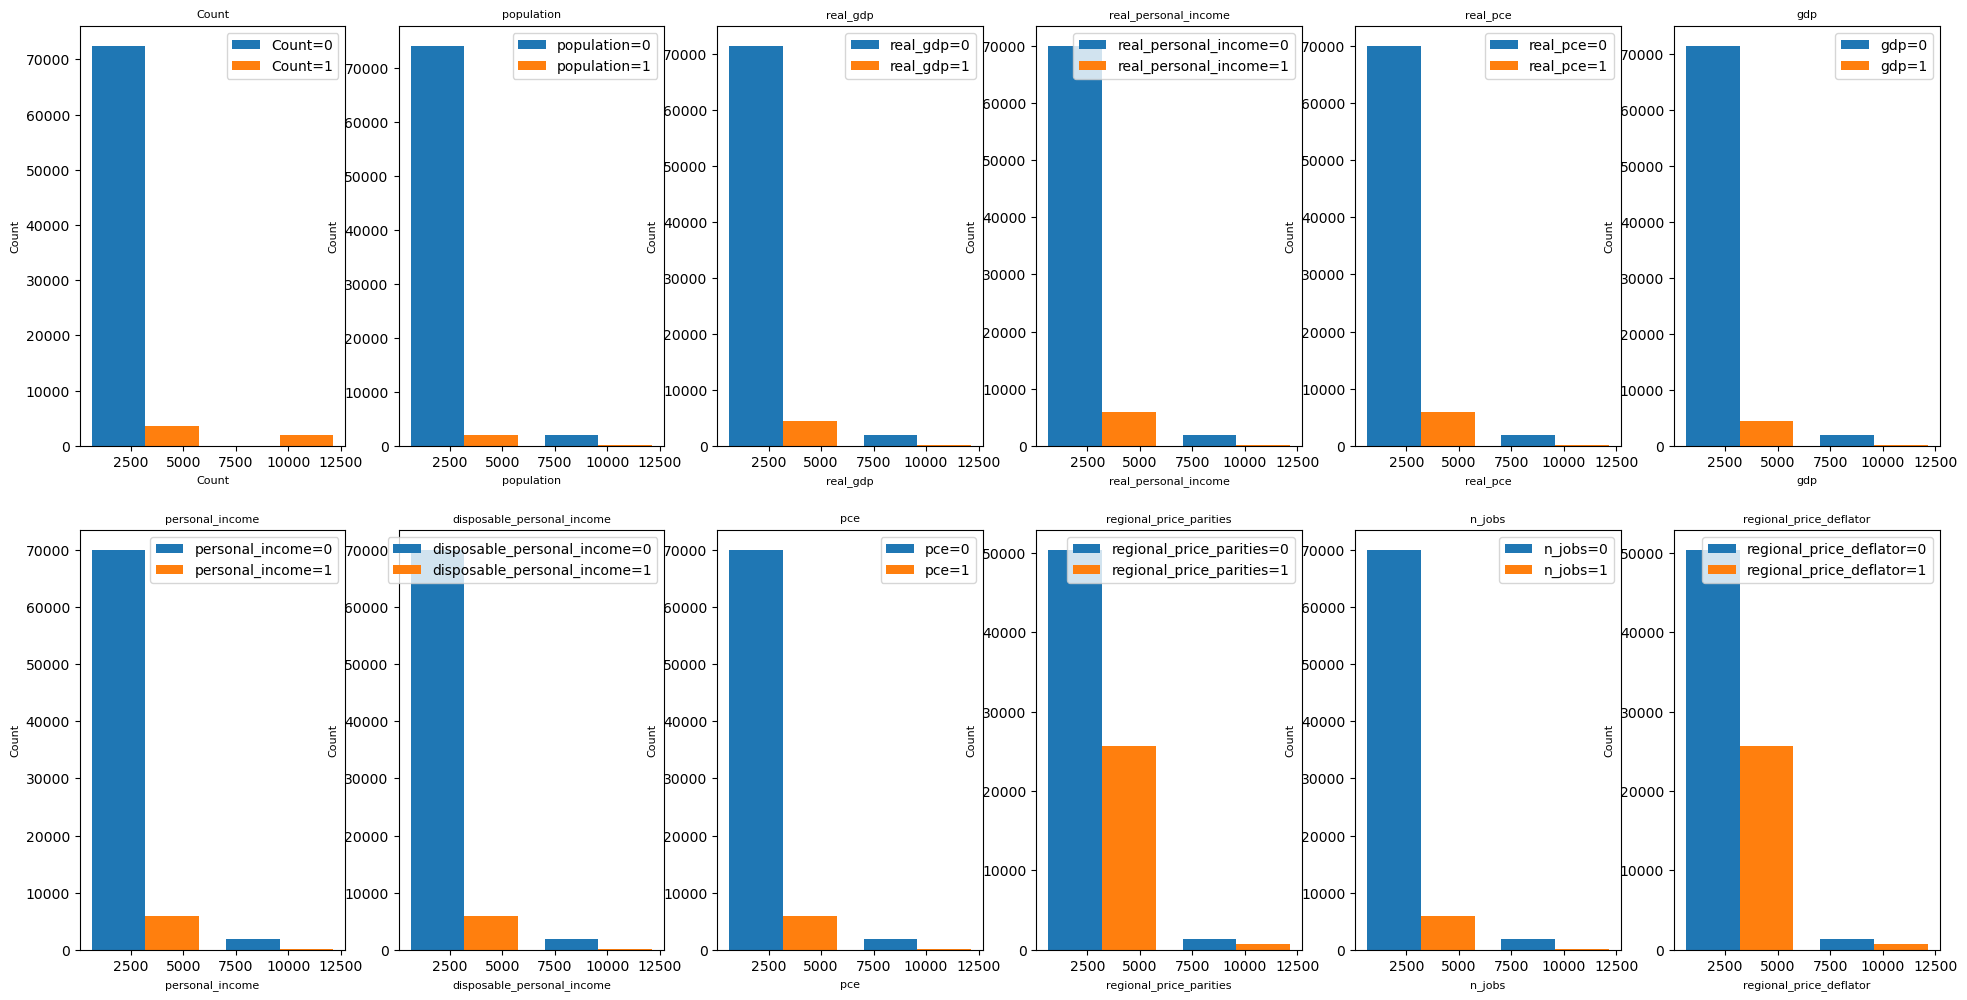

In [76]:
from sklearn.cluster import KMeans

features = ['Count','population',
       'real_gdp', 'real_personal_income', 'real_pce', 'gdp',
       'personal_income', 'disposable_personal_income', 'pce',
       'regional_price_parities', 'n_jobs', 'regional_price_deflator']

index = 0
fig, axs = plt.subplots(2, 6,figsize=(24, 12))
fontsize = 8

for ax in axs.flat:
    column = features[index]
    df = df_cancer_eco[df_cancer_eco['Leading Cancer Sites']=='Breast'].copy()       
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(df[[column]])
    df[column+'_cluster'] = kmeans.predict(df[[column]])

    ax.hist([df[df[column+'_cluster']==v]['Count'] for v in df[column+'_cluster'].unique()],bins=len(df[column+'_cluster'].unique()),label=[column +'='+str(v) for v in df[column+'_cluster'].unique()])
    ax.set_xlabel(column, fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_title(column, fontsize=fontsize)
    ax.legend()
    index = index + 1

### Lung and Bronchus Cancer Rates Prediction and Insights Visualization

In [77]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = data.values #scaler.fit_transform(data.values)
    df = pd.DataFrame(scaled)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

features = ['Count','population',
       'real_gdp', 'real_personal_income', 'real_pce', 'gdp',
       'personal_income', 'disposable_personal_income', 'pce',
       'regional_price_parities', 'n_jobs', 'regional_price_deflator']

df_cancer_shift = []
for k, g in df_cancer_eco[df_cancer_eco['Leading Cancer Sites']=='Lung and Bronchus'].groupby(['States','age_group','Sex']):
    
    r = series_to_supervised(g[features], n_in=1, n_out=1, dropnan=True)
    r = r.drop(r.columns[[i for i in range(len(features)+1, len(features)*2)]],axis=1)
    
    df_cancer_shift.append(r.values)
    

In [78]:
  
# split into train and test sets
values = np.array(df_cancer_shift)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values.reshape(-1,13))
values = scaled.reshape(-1,254,13)


In [79]:
n_train_hours = int(values.shape[0]*0.67)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:,:, :-1], train[:,:, -1]
test_X, test_y = test[:,:, :-1], test[:,:, -1]
train_X.shape, train_y.shape

((205, 254, 12), (205, 254))

In [80]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape(-1,12).reshape((-1, 1, 12))
test_X = test_X.reshape(-1,12).reshape((-1, 1, 12))
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 

(52070, 1, 12) (52070, 1) (25654, 1, 12) (25654, 1)


In [81]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)



Epoch 1/500
724/724 - 6s - loss: 0.0504 - val_loss: 0.0261 - 6s/epoch - 8ms/step
Epoch 2/500
724/724 - 3s - loss: 0.0068 - val_loss: 0.0055 - 3s/epoch - 4ms/step
Epoch 3/500
724/724 - 3s - loss: 0.0054 - val_loss: 0.0023 - 3s/epoch - 4ms/step
Epoch 4/500
724/724 - 3s - loss: 0.0042 - val_loss: 0.0036 - 3s/epoch - 4ms/step
Epoch 5/500
724/724 - 3s - loss: 0.0042 - val_loss: 0.0066 - 3s/epoch - 4ms/step
Epoch 6/500
724/724 - 3s - loss: 0.0034 - val_loss: 0.0039 - 3s/epoch - 4ms/step
Epoch 7/500
724/724 - 3s - loss: 0.0045 - val_loss: 0.0021 - 3s/epoch - 4ms/step
Epoch 8/500
724/724 - 3s - loss: 0.0040 - val_loss: 0.0075 - 3s/epoch - 4ms/step
Epoch 9/500
724/724 - 3s - loss: 0.0044 - val_loss: 0.0047 - 3s/epoch - 4ms/step
Epoch 10/500
724/724 - 3s - loss: 0.0044 - val_loss: 0.0125 - 3s/epoch - 4ms/step
Epoch 11/500
724/724 - 3s - loss: 0.0044 - val_loss: 0.0061 - 3s/epoch - 4ms/step
Epoch 12/500
724/724 - 3s - loss: 0.0043 - val_loss: 0.0066 - 3s/epoch - 4ms/step
Epoch 13/500
724/724 - 3s

724/724 - 3s - loss: 0.0039 - val_loss: 0.0063 - 3s/epoch - 4ms/step
Epoch 102/500
724/724 - 3s - loss: 0.0040 - val_loss: 0.0063 - 3s/epoch - 4ms/step
Epoch 103/500
724/724 - 3s - loss: 0.0032 - val_loss: 0.0024 - 3s/epoch - 4ms/step
Epoch 104/500
724/724 - 3s - loss: 0.0021 - val_loss: 0.0017 - 3s/epoch - 4ms/step
Epoch 105/500
724/724 - 3s - loss: 0.0021 - val_loss: 0.0027 - 3s/epoch - 4ms/step
Epoch 106/500
724/724 - 3s - loss: 0.0024 - val_loss: 0.0060 - 3s/epoch - 4ms/step
Epoch 107/500
724/724 - 3s - loss: 0.0034 - val_loss: 0.0024 - 3s/epoch - 4ms/step
Epoch 108/500
724/724 - 3s - loss: 0.0031 - val_loss: 0.0051 - 3s/epoch - 4ms/step
Epoch 109/500
724/724 - 3s - loss: 0.0029 - val_loss: 0.0078 - 3s/epoch - 4ms/step
Epoch 110/500
724/724 - 3s - loss: 0.0026 - val_loss: 0.0021 - 3s/epoch - 4ms/step
Epoch 111/500
724/724 - 3s - loss: 0.0024 - val_loss: 0.0021 - 3s/epoch - 4ms/step
Epoch 112/500
724/724 - 3s - loss: 0.0023 - val_loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 113/500
724/

Epoch 200/500
724/724 - 3s - loss: 0.0026 - val_loss: 0.0022 - 3s/epoch - 4ms/step
Epoch 201/500
724/724 - 3s - loss: 0.0026 - val_loss: 0.0091 - 3s/epoch - 4ms/step
Epoch 202/500
724/724 - 3s - loss: 0.0032 - val_loss: 0.0069 - 3s/epoch - 4ms/step
Epoch 203/500
724/724 - 3s - loss: 0.0028 - val_loss: 0.0043 - 3s/epoch - 4ms/step
Epoch 204/500
724/724 - 3s - loss: 0.0025 - val_loss: 0.0020 - 3s/epoch - 4ms/step
Epoch 205/500
724/724 - 3s - loss: 0.0033 - val_loss: 0.0028 - 3s/epoch - 4ms/step
Epoch 206/500
724/724 - 3s - loss: 0.0034 - val_loss: 0.0094 - 3s/epoch - 4ms/step
Epoch 207/500
724/724 - 3s - loss: 0.0034 - val_loss: 0.0040 - 3s/epoch - 4ms/step
Epoch 208/500
724/724 - 3s - loss: 0.0031 - val_loss: 0.0026 - 3s/epoch - 4ms/step
Epoch 209/500
724/724 - 3s - loss: 0.0035 - val_loss: 0.0032 - 3s/epoch - 4ms/step
Epoch 210/500
724/724 - 3s - loss: 0.0025 - val_loss: 0.0039 - 3s/epoch - 4ms/step
Epoch 211/500
724/724 - 3s - loss: 0.0035 - val_loss: 0.0066 - 3s/epoch - 4ms/step
Epoc

Epoch 299/500
724/724 - 3s - loss: 0.0019 - val_loss: 0.0023 - 3s/epoch - 4ms/step
Epoch 300/500
724/724 - 3s - loss: 0.0020 - val_loss: 0.0020 - 3s/epoch - 4ms/step
Epoch 301/500
724/724 - 3s - loss: 0.0031 - val_loss: 0.0053 - 3s/epoch - 4ms/step
Epoch 302/500
724/724 - 3s - loss: 0.0021 - val_loss: 0.0010 - 3s/epoch - 4ms/step
Epoch 303/500
724/724 - 3s - loss: 0.0028 - val_loss: 0.0020 - 3s/epoch - 4ms/step
Epoch 304/500
724/724 - 3s - loss: 0.0026 - val_loss: 0.0174 - 3s/epoch - 4ms/step
Epoch 305/500
724/724 - 3s - loss: 0.0028 - val_loss: 0.0019 - 3s/epoch - 4ms/step
Epoch 306/500
724/724 - 3s - loss: 0.0019 - val_loss: 0.0043 - 3s/epoch - 4ms/step
Epoch 307/500
724/724 - 3s - loss: 0.0030 - val_loss: 0.0053 - 3s/epoch - 3ms/step
Epoch 308/500
724/724 - 3s - loss: 0.0017 - val_loss: 0.0019 - 3s/epoch - 4ms/step
Epoch 309/500
724/724 - 3s - loss: 0.0015 - val_loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 310/500
724/724 - 3s - loss: 0.0029 - val_loss: 0.0032 - 3s/epoch - 4ms/step
Epoc

Epoch 398/500
724/724 - 3s - loss: 0.0020 - val_loss: 0.0079 - 3s/epoch - 4ms/step
Epoch 399/500
724/724 - 3s - loss: 0.0030 - val_loss: 0.0033 - 3s/epoch - 4ms/step
Epoch 400/500
724/724 - 3s - loss: 0.0021 - val_loss: 0.0020 - 3s/epoch - 4ms/step
Epoch 401/500
724/724 - 3s - loss: 0.0023 - val_loss: 0.0020 - 3s/epoch - 4ms/step
Epoch 402/500
724/724 - 3s - loss: 0.0021 - val_loss: 0.0039 - 3s/epoch - 4ms/step
Epoch 403/500
724/724 - 3s - loss: 0.0023 - val_loss: 0.0058 - 3s/epoch - 4ms/step
Epoch 404/500
724/724 - 3s - loss: 0.0020 - val_loss: 0.0058 - 3s/epoch - 4ms/step
Epoch 405/500
724/724 - 3s - loss: 0.0020 - val_loss: 0.0017 - 3s/epoch - 4ms/step
Epoch 406/500
724/724 - 3s - loss: 0.0024 - val_loss: 0.0010 - 3s/epoch - 4ms/step
Epoch 407/500
724/724 - 3s - loss: 0.0014 - val_loss: 0.0011 - 3s/epoch - 4ms/step
Epoch 408/500
724/724 - 3s - loss: 0.0012 - val_loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 409/500
724/724 - 4s - loss: 0.0017 - val_loss: 0.0024 - 4s/epoch - 5ms/step
Epoc

Epoch 496/500
724/724 - 3s - loss: 0.0022 - val_loss: 0.0063 - 3s/epoch - 4ms/step
Epoch 497/500
724/724 - 3s - loss: 0.0016 - val_loss: 0.0031 - 3s/epoch - 4ms/step
Epoch 498/500
724/724 - 3s - loss: 0.0021 - val_loss: 0.0119 - 3s/epoch - 4ms/step
Epoch 499/500
724/724 - 3s - loss: 0.0013 - val_loss: 0.0063 - 3s/epoch - 4ms/step
Epoch 500/500
724/724 - 3s - loss: 0.0014 - val_loss: 0.0029 - 3s/epoch - 4ms/step


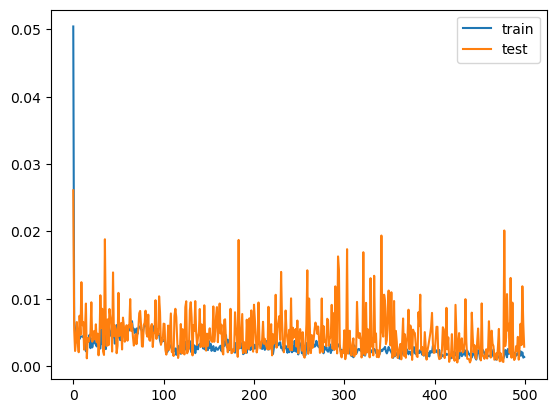

802/802 [==============================] - 2s 2ms/step
Test RMSE: 0.003


In [82]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# make a prediction
yhat = model.predict(test_X)
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_reshape[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### Insights for Population, Economic_Indicators vs. Lung and Bronchus Cancer Rates

In [83]:
df_cancer_eco_norm = pd.DataFrame(values.reshape(-1,13), columns=features+['y_count'])
df_cancer_eco_norm.head()

,Count,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator,y_count
0,0.0,0.024286,0.061554,0.081821,0.090461,0.058354,0.062827,0.066993,0.069570,0.145802,0.090952,0.059471,0.0
1,0.0,0.001132,0.009665,0.004442,0.005593,0.009203,0.004586,0.005114,0.005663,0.619351,0.002669,0.512419,0.0
2,0.0,0.034147,0.094846,0.112653,0.133844,0.089835,0.094553,0.099962,0.112315,0.414771,0.128802,0.316762,0.0
3,0.0,0.013323,0.031670,0.047126,0.048509,0.030009,0.035205,0.037437,0.036309,0.103779,0.050223,0.019268,0.0
4,0.0,0.229814,0.851631,0.874088,0.884391,0.804013,0.812191,0.817776,0.821112,0.807481,0.912118,0.692392,0.0


In [84]:
df_cancer_eco_norm.describe()

,Count,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator,y_count
count,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000
mean,0.108336,0.074244,0.121214,0.137274,0.144063,0.118381,0.120569,0.123858,0.126301,0.402989,0.143836,0.374859,0.108331
std,0.166687,0.123030,0.166408,0.175421,0.178109,0.161491,0.162860,0.164963,0.164712,0.240384,0.179344,0.243388,0.166697
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.004323,0.013034,0.019476,0.021542,0.026424,0.020812,0.018548,0.019831,0.022685,0.213511,0.022222,0.175963,0.004323
50%,0.041145,0.031866,0.064554,0.086123,0.090136,0.063778,0.069315,0.071739,0.075711,0.360763,0.090145,0.327620,0.040996
75%,0.147287,0.075683,0.161908,0.182045,0.185481,0.158031,0.158572,0.162514,0.168015,0.547023,0.178770,0.535235,0.147287
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [85]:
df_cancer_eco_norm.corr()

,Count,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator,y_count
Count,1.000000,0.237092,-0.000094,-0.000094,-0.000106,-0.000158,-0.000151,-0.000167,-0.000164,0.000102,-0.000084,-0.000948,0.999978
population,0.237092,1.000000,0.694251,0.703002,0.704919,0.692466,0.697902,0.700153,0.701442,0.209883,0.705042,0.205663,0.237098
real_gdp,-0.000094,0.694251,1.000000,0.993462,0.985547,0.998861,0.995286,0.994692,0.990316,0.374313,0.989588,0.369905,-0.000071
real_personal_income,-0.000094,0.703002,0.993462,1.000000,0.997799,0.992787,0.997231,0.998533,0.997659,0.338088,0.997919,0.337006,-0.000069
real_pce,-0.000106,0.704919,0.985547,0.997799,1.000000,0.984809,0.992494,0.994934,0.997058,0.320095,0.998080,0.319836,-0.000080
gdp,-0.000158,0.692466,0.998861,0.992787,0.984809,1.000000,0.996404,0.995037,0.991371,0.381080,0.987294,0.381925,-0.000134
personal_income,-0.000151,0.697902,0.995286,0.997231,0.992494,0.996404,1.000000,0.999464,0.998050,0.374626,0.992001,0.376470,-0.000126
disposable_personal_income,-0.000167,0.700153,0.994692,0.998533,0.994934,0.995037,0.999464,1.000000,0.998608,0.362625,0.994753,0.365506,-0.000143
pce,-0.000164,0.701442,0.990316,0.997659,0.997058,0.991371,0.998050,0.998608,1.000000,0.359070,0.994666,0.361858,-0.000139
regional_price_parities,0.000102,0.209883,0.374313,0.338088,0.320095,0.381080,0.374626,0.362625,0.359070,1.000000,0.316239,0.957046,0.000106


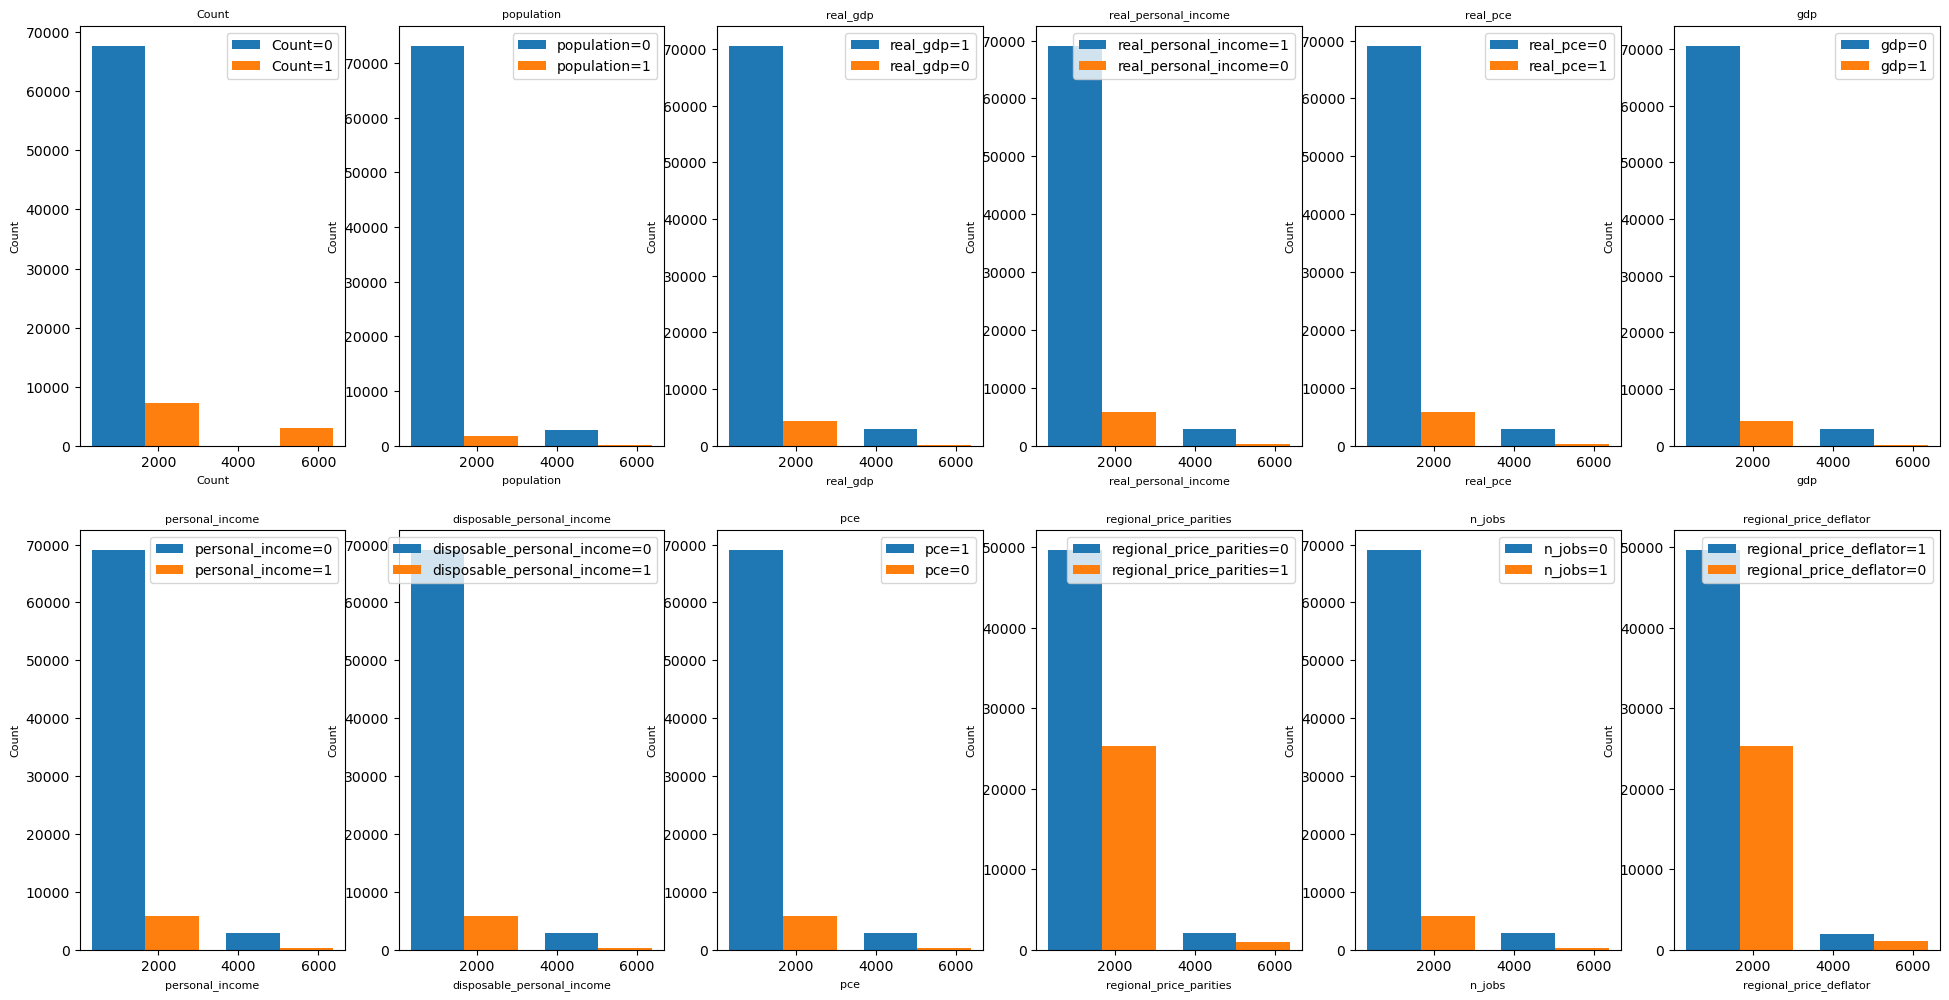

In [86]:
from sklearn.cluster import KMeans

features = ['Count','population',
       'real_gdp', 'real_personal_income', 'real_pce', 'gdp',
       'personal_income', 'disposable_personal_income', 'pce',
       'regional_price_parities', 'n_jobs', 'regional_price_deflator']

index = 0
fig, axs = plt.subplots(2, 6,figsize=(24, 12))
fontsize = 8

for ax in axs.flat:
    column = features[index]
    df = df_cancer_eco[df_cancer_eco['Leading Cancer Sites']=='Lung and Bronchus'].copy()       
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(df[[column]])
    df[column+'_cluster'] = kmeans.predict(df[[column]])

    ax.hist([df[df[column+'_cluster']==v]['Count'] for v in df[column+'_cluster'].unique()],bins=len(df[column+'_cluster'].unique()),label=[column +'='+str(v) for v in df[column+'_cluster'].unique()])
    ax.set_xlabel(column, fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_title(column, fontsize=fontsize)
    ax.legend()
    index = index + 1

### Melanoma of the Skin Cancer Rates Prediction and Insights Visualization

In [87]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = data.values #scaler.fit_transform(data.values)
    df = pd.DataFrame(scaled)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

features = ['Count','population',
       'real_gdp', 'real_personal_income', 'real_pce', 'gdp',
       'personal_income', 'disposable_personal_income', 'pce',
       'regional_price_parities', 'n_jobs', 'regional_price_deflator']

df_cancer_shift = []
for k, g in df_cancer_eco[df_cancer_eco['Leading Cancer Sites']=='Melanoma of the Skin'].groupby(['States','age_group','Sex']):
    
    r = series_to_supervised(g[features], n_in=1, n_out=1, dropnan=True)
    r = r.drop(r.columns[[i for i in range(len(features)+1, len(features)*2)]],axis=1)
    
    df_cancer_shift.append(r.values)
    

In [88]:
  
# split into train and test sets
values = np.array(df_cancer_shift)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values.reshape(-1,13))
values = scaled.reshape(-1,254,13)


In [89]:
n_train_hours = int(values.shape[0]*0.67)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:,:, :-1], train[:,:, -1]
test_X, test_y = test[:,:, :-1], test[:,:, -1]
train_X.shape, train_y.shape

((205, 254, 12), (205, 254))

In [90]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape(-1,12).reshape((-1, 1, 12))
test_X = test_X.reshape(-1,12).reshape((-1, 1, 12))
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 

(52070, 1, 12) (52070, 1) (25654, 1, 12) (25654, 1)


In [91]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)



Epoch 1/500
724/724 - 5s - loss: 0.0382 - val_loss: 0.0330 - 5s/epoch - 7ms/step
Epoch 2/500
724/724 - 3s - loss: 0.0073 - val_loss: 0.0082 - 3s/epoch - 4ms/step
Epoch 3/500
724/724 - 3s - loss: 0.0041 - val_loss: 0.0028 - 3s/epoch - 4ms/step
Epoch 4/500
724/724 - 3s - loss: 0.0021 - val_loss: 0.0064 - 3s/epoch - 4ms/step
Epoch 5/500
724/724 - 3s - loss: 0.0026 - val_loss: 0.0045 - 3s/epoch - 4ms/step
Epoch 6/500
724/724 - 3s - loss: 0.0015 - val_loss: 0.0047 - 3s/epoch - 4ms/step
Epoch 7/500
724/724 - 3s - loss: 0.0020 - val_loss: 0.0018 - 3s/epoch - 4ms/step
Epoch 8/500
724/724 - 3s - loss: 0.0026 - val_loss: 0.0019 - 3s/epoch - 3ms/step
Epoch 9/500
724/724 - 3s - loss: 0.0033 - val_loss: 0.0013 - 3s/epoch - 4ms/step
Epoch 10/500
724/724 - 3s - loss: 0.0018 - val_loss: 0.0043 - 3s/epoch - 4ms/step
Epoch 11/500
724/724 - 3s - loss: 0.0018 - val_loss: 0.0033 - 3s/epoch - 4ms/step
Epoch 12/500
724/724 - 3s - loss: 0.0019 - val_loss: 0.0018 - 3s/epoch - 4ms/step
Epoch 13/500
724/724 - 3s

724/724 - 3s - loss: 0.0042 - val_loss: 0.0043 - 3s/epoch - 4ms/step
Epoch 102/500
724/724 - 3s - loss: 0.0040 - val_loss: 0.0068 - 3s/epoch - 4ms/step
Epoch 103/500
724/724 - 3s - loss: 0.0036 - val_loss: 0.0024 - 3s/epoch - 4ms/step
Epoch 104/500
724/724 - 3s - loss: 0.0036 - val_loss: 0.0044 - 3s/epoch - 4ms/step
Epoch 105/500
724/724 - 3s - loss: 0.0039 - val_loss: 0.0044 - 3s/epoch - 4ms/step
Epoch 106/500
724/724 - 3s - loss: 0.0029 - val_loss: 0.0022 - 3s/epoch - 4ms/step
Epoch 107/500
724/724 - 3s - loss: 0.0038 - val_loss: 0.0052 - 3s/epoch - 5ms/step
Epoch 108/500
724/724 - 3s - loss: 0.0037 - val_loss: 0.0043 - 3s/epoch - 4ms/step
Epoch 109/500
724/724 - 3s - loss: 0.0037 - val_loss: 0.0034 - 3s/epoch - 4ms/step
Epoch 110/500
724/724 - 3s - loss: 0.0028 - val_loss: 0.0060 - 3s/epoch - 4ms/step
Epoch 111/500
724/724 - 3s - loss: 0.0041 - val_loss: 0.0022 - 3s/epoch - 4ms/step
Epoch 112/500
724/724 - 3s - loss: 0.0030 - val_loss: 0.0045 - 3s/epoch - 4ms/step
Epoch 113/500
724/

Epoch 200/500
724/724 - 3s - loss: 0.0020 - val_loss: 0.0035 - 3s/epoch - 4ms/step
Epoch 201/500
724/724 - 3s - loss: 0.0017 - val_loss: 0.0023 - 3s/epoch - 4ms/step
Epoch 202/500
724/724 - 3s - loss: 0.0021 - val_loss: 9.0597e-04 - 3s/epoch - 4ms/step
Epoch 203/500
724/724 - 3s - loss: 0.0021 - val_loss: 0.0013 - 3s/epoch - 4ms/step
Epoch 204/500
724/724 - 3s - loss: 0.0016 - val_loss: 8.3460e-04 - 3s/epoch - 4ms/step
Epoch 205/500
724/724 - 3s - loss: 0.0018 - val_loss: 0.0012 - 3s/epoch - 4ms/step
Epoch 206/500
724/724 - 3s - loss: 0.0018 - val_loss: 0.0044 - 3s/epoch - 3ms/step
Epoch 207/500
724/724 - 3s - loss: 0.0016 - val_loss: 0.0030 - 3s/epoch - 3ms/step
Epoch 208/500
724/724 - 3s - loss: 0.0018 - val_loss: 0.0013 - 3s/epoch - 3ms/step
Epoch 209/500
724/724 - 3s - loss: 0.0012 - val_loss: 0.0023 - 3s/epoch - 3ms/step
Epoch 210/500
724/724 - 3s - loss: 0.0016 - val_loss: 0.0010 - 3s/epoch - 3ms/step
Epoch 211/500
724/724 - 3s - loss: 0.0017 - val_loss: 0.0014 - 3s/epoch - 4ms/s

Epoch 297/500
724/724 - 3s - loss: 8.4321e-04 - val_loss: 0.0023 - 3s/epoch - 4ms/step
Epoch 298/500
724/724 - 3s - loss: 9.9697e-04 - val_loss: 2.6379e-04 - 3s/epoch - 4ms/step
Epoch 299/500
724/724 - 3s - loss: 0.0010 - val_loss: 0.0025 - 3s/epoch - 4ms/step
Epoch 300/500
724/724 - 3s - loss: 7.5795e-04 - val_loss: 8.8478e-04 - 3s/epoch - 4ms/step
Epoch 301/500
724/724 - 3s - loss: 5.6478e-04 - val_loss: 4.3072e-04 - 3s/epoch - 4ms/step
Epoch 302/500
724/724 - 3s - loss: 6.2517e-04 - val_loss: 0.0031 - 3s/epoch - 4ms/step
Epoch 303/500
724/724 - 3s - loss: 9.9700e-04 - val_loss: 0.0021 - 3s/epoch - 4ms/step
Epoch 304/500
724/724 - 3s - loss: 9.9687e-04 - val_loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 305/500
724/724 - 3s - loss: 8.2938e-04 - val_loss: 8.1670e-04 - 3s/epoch - 5ms/step
Epoch 306/500
724/724 - 3s - loss: 7.9584e-04 - val_loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 307/500
724/724 - 3s - loss: 0.0010 - val_loss: 0.0027 - 3s/epoch - 4ms/step
Epoch 308/500
724/724 - 3s - loss: 

Epoch 392/500
724/724 - 3s - loss: 6.2801e-04 - val_loss: 0.0030 - 3s/epoch - 4ms/step
Epoch 393/500
724/724 - 3s - loss: 8.7092e-04 - val_loss: 0.0066 - 3s/epoch - 4ms/step
Epoch 394/500
724/724 - 3s - loss: 8.4745e-04 - val_loss: 0.0011 - 3s/epoch - 5ms/step
Epoch 395/500
724/724 - 3s - loss: 9.4058e-04 - val_loss: 0.0022 - 3s/epoch - 5ms/step
Epoch 396/500
724/724 - 3s - loss: 7.1984e-04 - val_loss: 0.0034 - 3s/epoch - 4ms/step
Epoch 397/500
724/724 - 3s - loss: 9.5954e-04 - val_loss: 0.0019 - 3s/epoch - 4ms/step
Epoch 398/500
724/724 - 3s - loss: 8.3144e-04 - val_loss: 0.0031 - 3s/epoch - 4ms/step
Epoch 399/500
724/724 - 3s - loss: 8.3802e-04 - val_loss: 6.9551e-04 - 3s/epoch - 4ms/step
Epoch 400/500
724/724 - 3s - loss: 7.9823e-04 - val_loss: 0.0017 - 3s/epoch - 4ms/step
Epoch 401/500
724/724 - 3s - loss: 9.3038e-04 - val_loss: 0.0020 - 3s/epoch - 4ms/step
Epoch 402/500
724/724 - 3s - loss: 7.3000e-04 - val_loss: 6.9225e-04 - 3s/epoch - 4ms/step
Epoch 403/500
724/724 - 3s - loss: 

Epoch 486/500
724/724 - 3s - loss: 8.3006e-04 - val_loss: 0.0046 - 3s/epoch - 4ms/step
Epoch 487/500
724/724 - 3s - loss: 8.5108e-04 - val_loss: 5.8280e-04 - 3s/epoch - 4ms/step
Epoch 488/500
724/724 - 3s - loss: 9.2771e-04 - val_loss: 0.0011 - 3s/epoch - 4ms/step
Epoch 489/500
724/724 - 3s - loss: 0.0014 - val_loss: 0.0029 - 3s/epoch - 4ms/step
Epoch 490/500
724/724 - 3s - loss: 7.9932e-04 - val_loss: 0.0041 - 3s/epoch - 4ms/step
Epoch 491/500
724/724 - 3s - loss: 7.4379e-04 - val_loss: 0.0018 - 3s/epoch - 4ms/step
Epoch 492/500
724/724 - 3s - loss: 6.6816e-04 - val_loss: 3.3062e-04 - 3s/epoch - 4ms/step
Epoch 493/500
724/724 - 3s - loss: 7.2325e-04 - val_loss: 0.0010 - 3s/epoch - 4ms/step
Epoch 494/500
724/724 - 3s - loss: 0.0014 - val_loss: 0.0017 - 3s/epoch - 4ms/step
Epoch 495/500
724/724 - 3s - loss: 5.9304e-04 - val_loss: 7.2038e-04 - 3s/epoch - 4ms/step
Epoch 496/500
724/724 - 3s - loss: 7.3606e-04 - val_loss: 0.0040 - 3s/epoch - 4ms/step
Epoch 497/500
724/724 - 3s - loss: 0.00

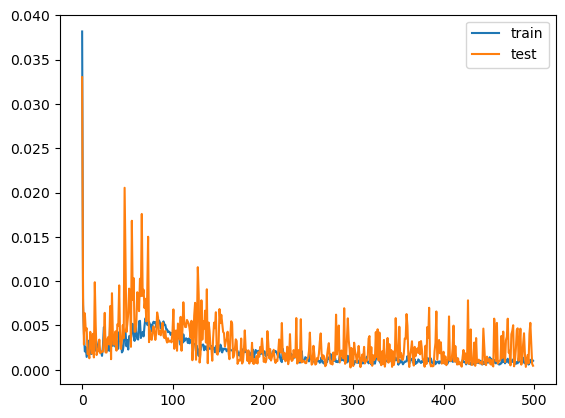

802/802 [==============================] - 2s 2ms/step
Test RMSE: 0.001


In [92]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# make a prediction
yhat = model.predict(test_X)
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_reshape[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### Insights for Population, Economic_Indicators vs. Melanoma of the Skin Cancer Rates

In [93]:
df_cancer_eco_norm = pd.DataFrame(values.reshape(-1,13), columns=features+['y_count'])
df_cancer_eco_norm.head()

,Count,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator,y_count
0,0.021386,0.024286,0.061554,0.081821,0.090461,0.058354,0.062827,0.066993,0.069570,0.145802,0.090952,0.059471,0.021386
1,0.021386,0.001132,0.009665,0.004442,0.005593,0.009203,0.004586,0.005114,0.005663,0.619351,0.002669,0.512419,0.021386
2,0.021386,0.034147,0.094846,0.112653,0.133844,0.089835,0.094553,0.099962,0.112315,0.414771,0.128802,0.316762,0.021386
3,0.021386,0.013323,0.031670,0.047126,0.048509,0.030009,0.035205,0.037437,0.036309,0.103779,0.050223,0.019268,0.021386
4,0.021386,0.229814,0.851631,0.874088,0.884391,0.804013,0.812191,0.817776,0.821112,0.807481,0.912118,0.692392,0.021386


In [94]:
df_cancer_eco_norm.describe()

,Count,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator,y_count
count,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000,77724.000000
mean,0.073001,0.074244,0.121214,0.137274,0.144063,0.118381,0.120569,0.123858,0.126301,0.402989,0.143836,0.374859,0.073018
std,0.104473,0.123030,0.166408,0.175421,0.178109,0.161491,0.162860,0.164963,0.164712,0.240384,0.179344,0.243388,0.104509
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.017055,0.013034,0.019476,0.021542,0.026424,0.020812,0.018548,0.019831,0.022685,0.213511,0.022222,0.175963,0.017055
50%,0.037899,0.031866,0.064554,0.086123,0.090136,0.063778,0.069315,0.071739,0.075711,0.360763,0.090145,0.327620,0.037899
75%,0.088251,0.075683,0.161908,0.182045,0.185481,0.158031,0.158572,0.162514,0.168015,0.547023,0.178770,0.535235,0.088251
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [95]:
df_cancer_eco_norm.corr()

,Count,population,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator,y_count
Count,1.000000,0.131318,0.000431,0.000605,0.000589,0.000678,0.000765,0.000765,0.000760,-0.000329,0.000395,0.003407,0.999924
population,0.131318,1.000000,0.694251,0.703002,0.704919,0.692466,0.697902,0.700153,0.701442,0.209883,0.705042,0.205663,0.131189
real_gdp,0.000431,0.694251,1.000000,0.993462,0.985547,0.998861,0.995286,0.994692,0.990316,0.374313,0.989588,0.369905,0.000314
real_personal_income,0.000605,0.703002,0.993462,1.000000,0.997799,0.992787,0.997231,0.998533,0.997659,0.338088,0.997919,0.337006,0.000476
real_pce,0.000589,0.704919,0.985547,0.997799,1.000000,0.984809,0.992494,0.994934,0.997058,0.320095,0.998080,0.319836,0.000454
gdp,0.000678,0.692466,0.998861,0.992787,0.984809,1.000000,0.996404,0.995037,0.991371,0.381080,0.987294,0.381925,0.000560
personal_income,0.000765,0.697902,0.995286,0.997231,0.992494,0.996404,1.000000,0.999464,0.998050,0.374626,0.992001,0.376470,0.000643
disposable_personal_income,0.000765,0.700153,0.994692,0.998533,0.994934,0.995037,0.999464,1.000000,0.998608,0.362625,0.994753,0.365506,0.000642
pce,0.000760,0.701442,0.990316,0.997659,0.997058,0.991371,0.998050,0.998608,1.000000,0.359070,0.994666,0.361858,0.000632
regional_price_parities,-0.000329,0.209883,0.374313,0.338088,0.320095,0.381080,0.374626,0.362625,0.359070,1.000000,0.316239,0.957046,-0.000322


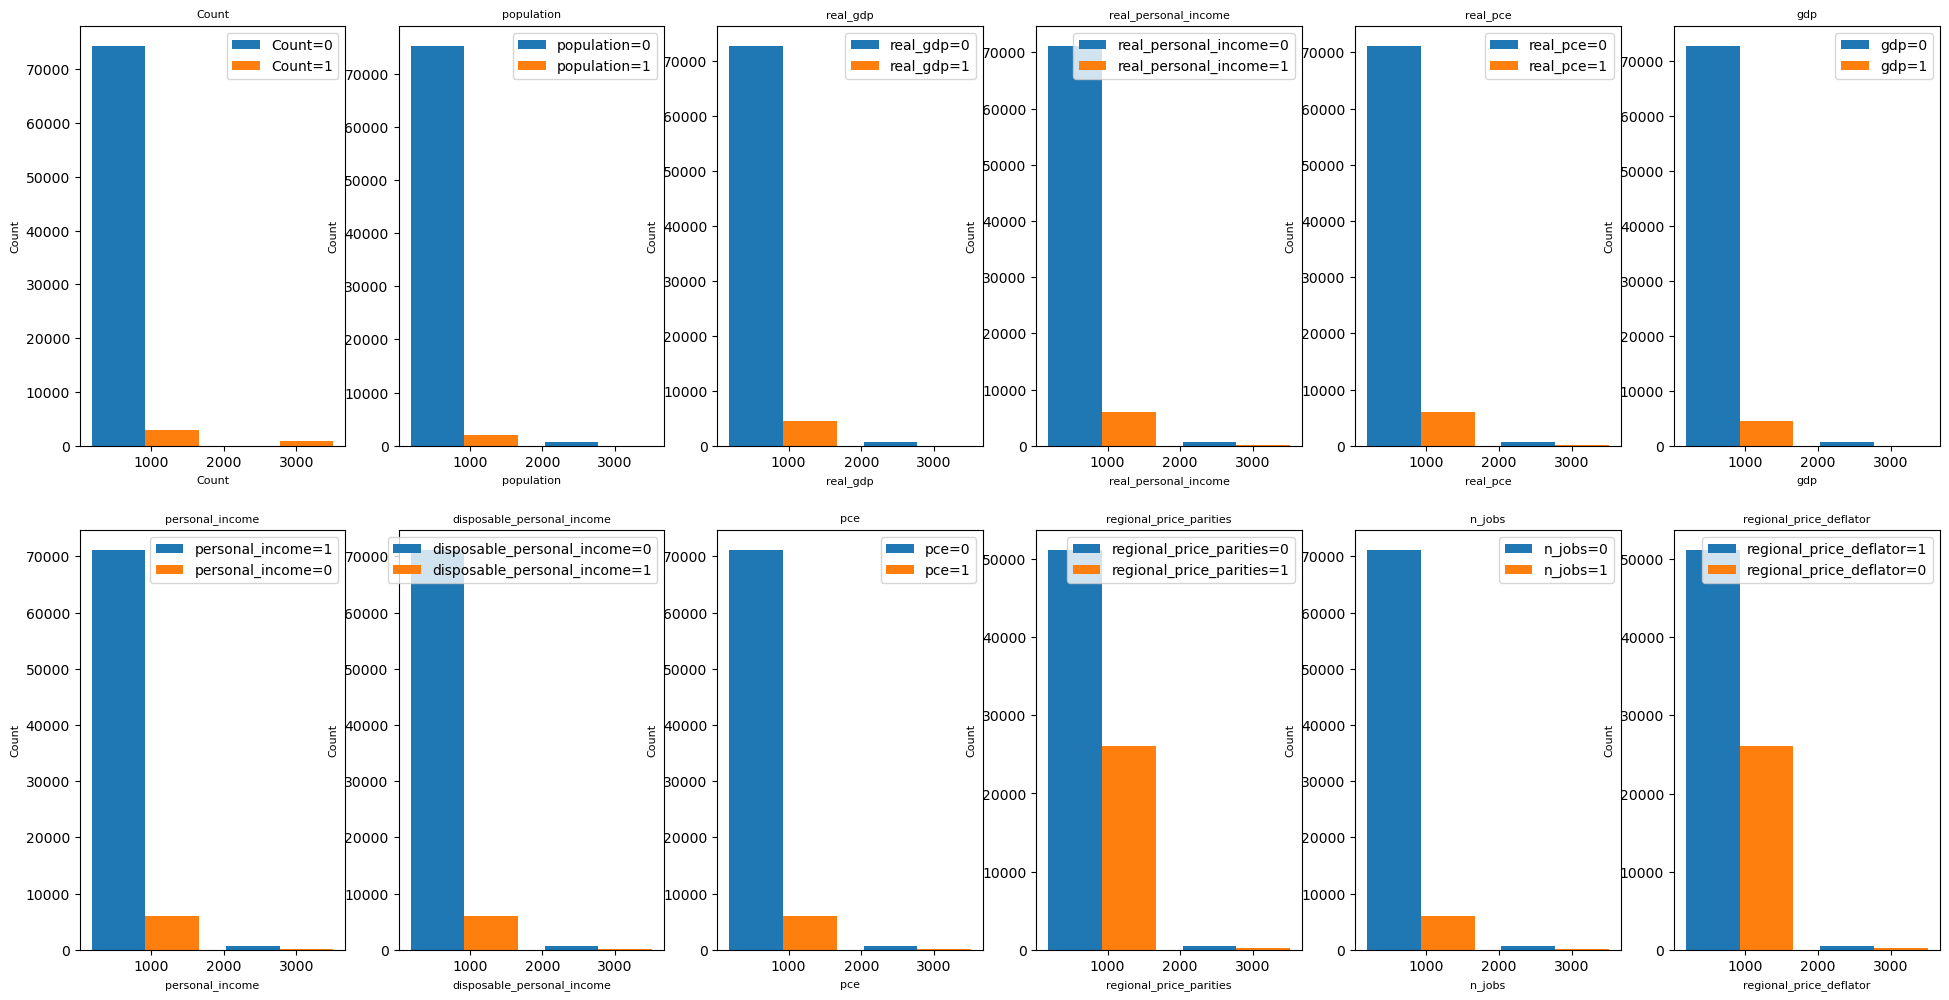

In [96]:
from sklearn.cluster import KMeans

features = ['Count','population',
       'real_gdp', 'real_personal_income', 'real_pce', 'gdp',
       'personal_income', 'disposable_personal_income', 'pce',
       'regional_price_parities', 'n_jobs', 'regional_price_deflator']

index = 0
fig, axs = plt.subplots(2, 6,figsize=(24, 12))
fontsize = 8

for ax in axs.flat:
    column = features[index]
    df = df_cancer_eco[df_cancer_eco['Leading Cancer Sites']=='Melanoma of the Skin'].copy()       
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(df[[column]])
    df[column+'_cluster'] = kmeans.predict(df[[column]])

    ax.hist([df[df[column+'_cluster']==v]['Count'] for v in df[column+'_cluster'].unique()],bins=len(df[column+'_cluster'].unique()),label=[column +'='+str(v) for v in df[column+'_cluster'].unique()])
    ax.set_xlabel(column, fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_title(column, fontsize=fontsize)
    ax.legend()
    index = index + 1